# Database Constructor

The data ingest route is designed to be tolerant of a certain amount of sloppiness in the way metadata describing documents is provided, but it still has certain expectations...

In [23]:
from sqlite_utils import Database

db_name = "demo.db"

# Uncomment the following lines to connect to a pre-existing database
db = Database(db_name)

In [24]:
# Do not run this cell if your database already exists!

# While developing the script, recreate database each time...
db = Database(db_name, recreate=True)

# This schema has been evolved iteratively as I have identified structure
# that can be usefully mined...

db["sources"].create({
    "url": str,
    "fn": str,
    "publication": str,
    "published_date": str, # this may range from year to actual date
    "volume": str, # or volume like...
    "title": int, # Title of section
    "date": str, # optional; the second date field; may be eg correspondence date
    "author": str, # attempt at provenance
    "pages": str, # or pages like
    "text": str,
},# pk=("url", "title") # Need an autoincrement; no natural key?
)

# Enable full text search
# This creates an extra virtual table (books_fts) to support the full text search
db["sources"].enable_fts(["publication","title", "text", "published_date"], create_triggers=True)

<Table sources (url, fn, publication, published_date, volume, title, date, author, pages, text)>

In [25]:
#!ls

## Parse Data Files

This attempts to be forgiving...

In [26]:
fn = "NANDQ_notes-and-queries.md"

def get_file_contents(fn):
    """Open file from filename and get file contents."""
    with open(fn) as f:
        txt = f.read().strip()
    return txt

txt = get_file_contents(fn)
txt[:100]

'---\n\nhttps://archive.org/details/notesqueries01londuoft/page/n9/mode/2up\n\n\nNotes and Queries No. 1\n\n'

In [27]:
def get_sections(txt):
    """Get sections from file."""
    txt_sections = [s.strip('-').strip() for s in txt.split("---") if s.strip('-').strip()]
    return txt_sections

txt_sections = get_sections(txt)
txt_sections

['https://archive.org/details/notesqueries01londuoft/page/n9/mode/2up\n\n\nNotes and Queries No. 1\n\nSaturday, November 3rd, 1849\n\np.1-3\n\n>NOTES AND QUERIES.\n>\n> THE nature and design of the present work have been so fully stated in the Prospectus, and are indeed so far explained by its very Title, that it is unnecessary to occupy any great portion of its first number with details on the subject. We are under no temptation to fill its columns with an account of what we hope future numbers will be. Indeed, we would rather give a specimen than a description; and only regret that, from the wide range of subjects which it is intended to embrace, and the correspondence and contributions of various kinds which we are led to expect, even this can only be done gradually. A few words of introduction and explanation may, however, be allowed; and, indeed, ought to be prefixed, that we may be understood,.by those readers who have not seen our Prospectus.\n\n"WHEN FOUND, MAKE A NOTE OF," is 

In [28]:
#%pip install dateparser
# https://dateparser.readthedocs.io/en/latest/usage.html
from dateparser.date import DateDataParser

ddp = DateDataParser(languages=['en'])

In [29]:
import re

# Example page search
m = re.search(r"^pp?\.?\s?([0-9\?].*)", "pp.23-34")
if m:
    print(m.group(1))

23-34


In [30]:
import re

dt = "%Y-%m-%d"

def parse_sections(txt_sections, fn=None):
    """Parse file section."""
    records = []
    for section in txt_sections:
        txt_lines = [l.strip() for l in section.split('\n') if l.strip()]
        #print(txt_lines)
        record = {"fn":fn}
        for i, line in enumerate(txt_lines):
            line = line.strip()
            # This is inefficient...
            # We should test as fallback...
            try_url = line.startswith("http")
            try_date = ddp.get_date_data(line.replace('Publication date', '').strip())
            try_pages = re.search(r"^pp?\.?\s?([0-9\?].*)", line)

            if try_url:
                record["url"] = line
            elif try_date["date_obj"]:
                if "published_date" in record:
                    record["date"] = try_date.date_obj.strftime(dt)
                else:
                    record["published_date"] = try_date.date_obj.strftime(dt)
            elif try_pages:
                record["pages"] = try_pages.group(1)
            elif not "publication" in record:
                record["publication"] = line

            # We take pages as the last item of metadata...
            if try_pages:
                break
        if len(txt_lines[i+1])>200:
            record["title"] = txt_lines[i+1][:100]
            record["text"] = "\n".join(txt_lines[i+1:])[100:]
        else:
            record["title"] = txt_lines[i+1]
            record["text"] = "\n".join(txt_lines[i+2:])
        records.append(record)

    return records

In [31]:
# Attempt at full run

import os

all_records = []

for fn in [fn for fn in os.listdir() if fn.endswith(".md") and not fn.startswith("_") and not fn.startswith("README")]:
    print(fn)
    txt = get_file_contents(fn)
    txt_sections = get_sections(txt)
    records = parse_sections(txt_sections, fn)
    all_records = all_records + records
    
## Add to DB
#db_tbl.upsert_all(book_items, pk=("book", "title" ))
db["sources"].insert_all(all_records)

TNTOS_toronto-saturday-night.md
WFCST_welsh-folk-customs-owen.md
BRMAG_british-magazine.md
WGZWW_welsh-gazette-west-wales-advertiser.md
OEHEL_elton-origins-english-history.md
PAATQ_parochial-antiquities-kennett.md
MNPST_morning-post.md
LLADM_llangollen-advertiser-denbighshire-merionethshire-north-wales-journal.md
WKLYM_weekly-mail.md
PATQD_popular-antiquities-faiths-folklore-dictionary.md
MNDEC_mountain-decameron.md


/usr/local/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


CNTRV_contemporary-review.md
INPRA_in-praise-ale-marchant.md
JNBLL_john-bull.md
FLMWD_folklore-west-mid-wales-davies.md
ETHFL_ethnology-in-folklore-gomme.md
SHRWC_shrewsbury-chronicle.md
HWLCS_howell_cambrian_superstitions.md
WNSWR_roscoe-wanderings-south-wales.md
SWDPT_south-wales-daily-post.md
ANTQR_antiquarian-repertory-astle.md
SRVCH_survivals-in-christianity-wood.md
HBKTM_handbook-travellers-south-wales-murray.md
JNLAI_journal-anthropological-institute.md
GNLMN_gentlemans-magazine.md
OLBRK_old_brecknock_chips.md
BRYHD_barry-herald.md
PPCWM_pontypridd-chronicle-workmans-news.md
TRNGW_tarian-gweithiwr.md
SWLSE_south-wales-echo.md
GSAEW_grose_antiquities_england_wales.md
NWEXP_north-wales-express.md
SUNLN_sun.md
PFNDR_pathfinder.md
BRASS_british-association.md
CNNSR_connoisseur.md
BTBSE_phillips-beyond-border-sin-eater.md
CMBNM_cambrian-news-merionethshire-standard.md
BEIRN_beirniad.md
FLWSN_folklore-west-scotland-napier.md
ANTQS_antiquities-pendine-curtis.md
ARCHS_archaeological-ske

<Table sources (url, fn, publication, published_date, volume, title, date, author, pages, text)>

In [32]:
for r in all_records:
    if "published_date" in r:
        print(r["published_date"])
    else:
        print("no date?", r["fn"])

1899-03-18
1959-01-06
1835-04-01
1904-03-03
1890-01-06
1818-01-06
1836-05-21
1836-06-20
1895-10-18
1883-05-05
1883-06-23
1895-09-21
1902-08-16
1895-10-19
1909-05-15
1909-09-04
1905-01-06
1905-01-06
1836-01-06
1836-01-06
1836-01-06
1836-01-06
1896-02-06
1888-01-06
1836-06-12
1911-01-06
1892-01-06
1852-09-03
1852-11-05
1880-10-08
1831-01-06
1854-01-06
1854-01-06
1895-09-16
1896-06-02
1775-01-06
1807-01-06
1893-01-06
1893-01-06
1860-01-06
1875-01-06
1822-03-06
1837-10-06
1887-05-27
1898-05-06
1892-06-03
1909-09-16
1895-10-29
1785-01-06
1880-01-23
1895-10-04
1836-06-17
1932-09-24
1895-01-06
1895-08-15
1895-08-29
1755-03-13
2020-01-06
1874-05-22
1875-11-19
1875-11-26
1875-12-24
1876-02-18
1876-03-10
1879-12-12
1901-01-18
1862-01-06
1879-01-06
1880-01-06
1880-01-06
1821-01-06
1832-01-06
1880-01-06
1774-01-06
1895-11-14
1896-03-12
1897-03-25
1880-10-06
1888-01-06
1895-07-27
1904-01-06
1885-05-16
1885-06-06
1885-07-25
1892-06-11
1895-11-02
1902-08-02
1895-01-06
1909-09-24
1883-03-06
1883-04-06

## Test Query DB


In [33]:
q = '"ease and rest"'

# The `.search()` method knows how to find the full text search table
# given the original table name
#for story in db["sources"].search(db.quote_fts(q), columns=["title", "text"]):
#    print(story)

_q = f'SELECT publication, title FROM sources_fts WHERE sources_fts MATCH {db.quote(q)} ORDER BY published_date ASC LIMIT 15 ;'
for row in db.query(_q):
    print(row["publication"], row["title"])

Bye-gones, Februry 24, 1892 THE CYMMRODORION SOCIETY.
Observations on popular antiquities, chiefly illustrating the origin of our vulgar customs, ceremonies and superstitions: Arranged and rev., with additions SIN EATERS
Ariconensia, or, Archaeological sketches of Ross and Archenfield: illustrative of the campaigns of Caractacus, the station Ariconium, &c, with other matters never before published The following are matters which the author ascribes to the middle ages, at least he can assign no earlier date.
The Gentleman's Magazine  1822-03: Vol 92 The following are matters which the author ascribes to the middle ages, at least he can assign no earlier date.
The year book of daily recreation and information: The year book of daily recreation and information: concerning remarkable men and manners, times and
Observations on the popular antiquities of Great Britain: chiefly illustrating the origin of our vulgar and provincial customs, ceremonies, and superstitions p. 245-6]
Observation On

In [34]:
_q = f"""
SELECT title, snippet(sources_fts, -1, "**", "**", "...", 30) as clip
FROM sources_fts WHERE sources_fts MATCH {db.quote(q)} LIMIT 5 ;
"""

for row in db.query(_q):
    print(row["clip"])

...After this, he got up from the cricket and pronounced, with a composed gesture, the **ease and rest** of the soul departed, for which he would pawn his own soul...
...Finally, he rose from the cricket, and with a composed gesture pronounced "the **ease and rest** of the soul departed, for which he would pawn his own soul". In Hereford...
...After this he got up from the cricket and pronounced with a composed gesture the **ease and rest** of the soul departed, for which he would pawn his own soul...
...office was, for a trifling compensation to pawn his own soul for the **ease and rest** of the soul departed. Mr. Ellis, the editor of the Popular Antiquities, has extracted...
...A groat, a crust of brea 1, and a lull bowl of ale were given to him, after the con- sumption of which he rose and pronounced the "**ease and**...


In [35]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "17%" ORDER BY published_date ASC LIMIT 15 ;
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

ANTQT_antiquitates-vulgares-bourne.md 1725-01-06
CNNSR_connoisseur.md 1755-03-13
CLCTN_collectanea-leland.md 1774-01-06
ANTQR_antiquarian-repertory-astle.md 1775-01-06
PAOBS_observations-popular-antiquities_brand.md 1777-01-06
TIWPN_tours-in-wales-pennant.md 1783-01-06
GSAEW_grose_antiquities_england_wales.md 1785-01-06
GSPGS_grose_provincial_glossary.md 1787-01-06


In [36]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "186%" OR published_date LIKE "1854%" ORDER BY published_date ASC LIMIT 15 ;
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

WNSWR_roscoe-wanderings-south-wales.md 1854-01-06
HBKTM_handbook-travellers-south-wales-murray.md 1860-01-06
BEIRN_beirniad.md 1862-01-06
EDJNL_eddowes-journal-shropshire-wales.md 1862-12-10
WLSHM_the-welshman.md 1862-12-12
HFDJL_hereford-journal.md 1862-12-20


In [56]:
def seed_md(q, fn, quote=True):
    """Seed a new markdown file with content from searches."""
    # Run query
    results = db.query(q)
    with open(f"new-{fn}", "w") as f:
        # for each result
        for row in results:
            if 'url' in row:
                f.write(f"\n{row['url']}\n\n")
            else:
                f.write(f"\nTO DO - NO URL\n\n")
            # - get and write attribution
            if 'publication' not in row:
                row['publication'] = "TO DO - NO PUBLICATION"
            if 'pages' not in row:
                row['pages'] = 'TO DO - NO PAGES'
            if 'title' not in row:
                row['title'] = 'TO DO - NO TITLE'
            if 'text' not in row:
                row['text'] = 'TO DO - NO TEXT'
            attribution = f'{row["publication"]}\n\n{row["published_date"]}\n\np{row["pages"]}\n\n'
            f.write(attribution)
            title = row["title"]
            # - get text
            txt = row["text"]
            # - optionally split, prefix with quote, and rejoin
            if quote:
                lines = [title] + txt.split("\n")
                lines = [f"> {l}" for l in lines]
                txt = "\n>\n".join(lines)
            else:
                f.write(f'{title}\n\n')
            # - write (optionally processed) text
            f.write(txt)
            f.write("\n\n---\n\n")

In [38]:
_q = f"""
SELECT fn, publication, url, title, text, pages, published_date FROM sources WHERE published_date LIKE "186%" OR published_date LIKE "1854%" ORDER BY published_date ASC LIMIT 15 ;
"""
seed_md(_q, "interim.md")

In [39]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "187%" ORDER BY published_date ASC
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

_q = f"""
SELECT fn, publication, url, title, text, pages, published_date FROM sources WHERE published_date LIKE "187%" ORDER BY published_date ASC ;
"""
seed_md(_q, "first_controversy.md")

BYGNS_bye-gones.md 1871-10-04
BYGNS_bye-gones.md 1872-02-06
BYGNS_bye-gones.md 1874-05-20
CMBNM_cambrian-news-merionethshire-standard.md 1874-05-22
JNLAI_journal-anthropological-institute.md 1875-01-06
ACDMY_the-academy.md 1875-11-06
BLKWD_blackwoods.md 1875-11-06
ACDMY_the-academy.md 1875-11-13
CMBNM_cambrian-news-merionethshire-standard.md 1875-11-19
ACDMY_the-academy.md 1875-11-20
ABERO_aberystwith-observer.md 1875-11-20
BYGNS_bye-gones.md 1875-11-24
CMBNM_cambrian-news-merionethshire-standard.md 1875-11-26
ACDMY_the-academy.md 1875-11-27
BYGNS_bye-gones.md 1875-12-01
ABERO_aberystwith-observer.md 1875-12-11
ABERO_aberystwith-observer.md 1875-12-18
BYGNS_bye-gones.md 1875-12-22
CMBNM_cambrian-news-merionethshire-standard.md 1875-12-24
ACDMY_the-academy.md 1876-02-05
HSTNT_historical-notes-rowlands.md 1876-02-05
BYGNS_bye-gones.md 1876-02-09
ACDMY_the-academy.md 1876-02-12
ABERO_aberystwith-observer.md 1876-02-12
CMBNM_cambrian-news-merionethshire-standard.md 1876-02-18
ACDMY_the-aca

In [58]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "188%" ORDER BY published_date ASC ;
"""

_q = f"""
SELECT fn, publication, url, title, text, pages, published_date FROM sources WHERE published_date LIKE "188%" ORDER BY published_date ASC ;
"""

seed_md(_q, "interim_1888.md")

#for row in db.query(_q):
#    print(row["fn"], row["published_date"])

In [45]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "189%" ORDER BY published_date ASC ;
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

OEHEL_elton-origins-english-history.md 1890-01-06
GLDNB_golden-bough-frazer.md 1890-01-06
BYGNS_bye-gones.md 1890-06-25
CMBRN_cambrian.md 1891-10-16
CMBRN_cambrian.md 1891-10-30
ETHFL_ethnology-in-folklore-gomme.md 1892-01-06
TRNLW_transactions_liverpool_welsh_society.md 1892-01-06
FLKLR_folklore.md 1892-01-06
WSTNM_western-mail.md 1892-01-22
CNDBH_carnarvon-denbigh-herald.md 1892-01-29
WLSRV_welsh_review.md 1892-03-06
PPCWM_pontypridd-chronicle-workmans-news.md 1892-06-03
CRDFT_cardiff-times.md 1892-06-11
OSWAD_oswestry-advertiser.md 1892-06-29
SRVCH_survivals-in-christianity-wood.md 1893-01-06
FLKLR_folklore.md 1893-01-06
ABERO_aberystwith-observer.md 1893-04-20
BYGNS_bye-gones.md 1893-10-11
PERSH_hartland-perseus.md 1894-01-06
EVEXP_evening-express.md 1894-07-04
WSTNM_western-mail.md 1894-09-21
BRASS_british-association.md 1895-01-06
HHTLA_household-tales-addy.md 1895-01-06
SEMAC_sin-eater-macleod.md 1895-01-06
PRSNW_pearsons-weekly.md 1895-07-27
BRASS_british-association.md 1895-08

In [42]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "1852%" OR published_date LIKE "185%" ORDER BY published_date ASC LIMIT 15 ;
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

NANDQ_notes-and-queries.md 1851-03-29
NANDQ_notes-and-queries.md 1851-04-12
NANDQ_notes-and-queries.md 1851-06-07
NANDQ_notes-and-queries.md 1851-09-20
ARCHC_archaeologia-cambrensis.md 1851-10-06
HFDJL_hereford-journal.md 1852-09-01
SHRWC_shrewsbury-chronicle.md 1852-09-03
NWCAPnorth-wales-chronicle-advertiser-principality.md 1852-09-03
HFDTM_hereford-times.md 1852-09-04
ARCHC_archaeologia-cambrensis.md 1852-10-06
NANDQ_notes-and-queries.md 1852-10-23
GMBCZ_glamorgan-monmouth-brecon-gazette-merthyr-cardiff-guardian.md 1852-10-30
SHRWC_shrewsbury-chronicle.md 1852-11-05
NANDQ_notes-and-queries.md 1852-12-04
WNSWR_roscoe-wanderings-south-wales.md 1854-01-06


In [43]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE published_date LIKE "17%" OR published_date LIKE "181%" OR published_date LIKE "186%"  OR published_date LIKE "185%" OR published_date LIKE "180%" OR published_date LIKE "181%" OR published_date LIKE "182%" OR published_date LIKE "183%"  OR published_date LIKE "184%" ORDER BY published_date ASC ;
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

ANTQT_antiquitates-vulgares-bourne.md 1725-01-06
CNNSR_connoisseur.md 1755-03-13
CLCTN_collectanea-leland.md 1774-01-06
ANTQR_antiquarian-repertory-astle.md 1775-01-06
PAOBS_observations-popular-antiquities_brand.md 1777-01-06
TIWPN_tours-in-wales-pennant.md 1783-01-06
GSAEW_grose_antiquities_england_wales.md 1785-01-06
GSPGS_grose_provincial_glossary.md 1787-01-06
NWBNG_north-wales-bingley.md 1804-01-06
ANTQR_antiquarian-repertory-astle.md 1807-01-06
PAOBS_observations-popular-antiquities_brand.md 1813-01-06
PAATQ_parochial-antiquities-kennett.md 1818-01-06
ARCHS_archaeological-sketches-ross.md 1821-01-06
GNLMN_gentlemans-magazine.md 1822-03-06
ENCWP_english-chronicle-whitehall-eveing-post.md 1822-11-02
HWLCS_howell_cambrian_superstitions.md 1831-01-06
YBECH_hone-yearbook-recreation.md 1832-01-06
SCTMN_the-scotsman.md 1832-02-18
INVCR_inverness-courier.md 1832-06-06
LNCEG_london-courier-evening-gazette.md 1832-07-17
BRMAG_british-magazine.md 1835-04-01
MNDEC_mountain-decameron.md 1836

In [44]:
_q = f"""
SELECT DISTINCT(fn), published_date FROM sources WHERE text LIKE "%Decameron%" AND (published_date LIKE "17%" OR published_date LIKE "181%" OR published_date LIKE "180%" OR published_date LIKE "181%" OR published_date LIKE "182%" OR published_date LIKE "183%"  OR published_date LIKE "184%")  ORDER BY published_date ASC ;
"""

for row in db.query(_q):
    print(row["fn"], row["published_date"])

MNDEC_mountain-decameron.md 1836-01-06
MNPST_morning-post.md 1836-05-21
MHRLD_morning-herald.md 1836-06-04
GMBCZ_glamorgan-monmouth-brecon-gazette-merthyr-cardiff-guardian.md 1836-06-04
GMBCZ_glamorgan-monmouth-brecon-gazette-merthyr-cardiff-guardian.md 1836-06-11
JNBLL_john-bull.md 1836-06-12
SUNLN_sun.md 1836-06-17
GMBCZ_glamorgan-monmouth-brecon-gazette-merthyr-cardiff-guardian.md 1836-06-18
MNPST_morning-post.md 1836-06-20


## Full Text

In [301]:
import requests

from bs4 import BeautifulSoup

url = "https://archive.org/stream/oldenglishfairyt00bari/oldenglishfairyt00bari_djvu.txt"

resp = requests.get(url)

soup = BeautifulSoup(resp.content, "html.parser")

# Find the spans containing the links
txt = soup.find("pre").text

txt[:3000]

'wm \n\n\n\nuniversity of \n\nConnecticut \n\nlibraries \n\n\n\n\n5 \n\ntd \n\n\n\nOLD ENGLISH FAIRY TALES \n\n\n\nOLD \nENGLISH FAIRY TALES \n\n\n\nCOLLECTED BY \n\n\n\nS. BARING GOULD, M.A. \n\nAUTHOR OF "mEHALAH" " THE TRAGEDY OF THE CAESARS \' \n"old COUNTRY life" ETC. \n\n\n\nILLUSTRATED BY F. D. BEDFORD \n\n\n\nMETHUEN & CO. \n\n36 ESSEX STREET, W. C. \n\nLONDON \n\n1895 \n\n\n\n\n7- \n\n\n\n\nPREFACE \n\n\n\nIt has been to me a matter of surprise that no \ncollection has been made and adapted to the reading \nof children of the old delightful English folk tales \nand traditionary stories that exist, scattered up and \ndown in all manner of places. \n\nWe have had for their delectation numerous \neditions of the French tales of Perault and the \nCountess D\'Aulnoy, and the German stories ot \nGrimm, but our own native springs have been \nneglected. There is a singular perversity in the \nEnglish character — that it will seek abroad, and \nand value what is foreign, and neglect an

## Get archive.org  / PDF text

In [4]:
import PyPDF2 

# creating a pdf file object 
f2='/Users/tonyhirst/Downloads/beirniad2_.pdf'

# THIS IS NOT RELIABLE. EG the following doesn't give anything; okay with Apache pdfbox
f2 = "/Users/tonyhirst/Documents/storytelling/fairy tale collections/English_Fairy_Tales - Jacobs.pdf"
pdfFileObj = open(f2, 'rb') 


# creating a pdf reader object 
pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
    
# printing number of pages in pdf file 
print(pdfReader.numPages) 
    
# creating a page object 
pageObj = pdfReader.getPage(10) 
    
# extracting text from page 
print(pageObj.extractText()) 
    
# closing the pdf file object 
pdfFileObj.close() 

299


















In [4]:
#Trying: https://github.com/lebedov/python-pdfbox/ but just hangs for me on extract
import appdirs
import pathlib
a = appdirs.AppDirs('python-pdfbox')
cache_dir = pathlib.Path(a.user_cache_dir)
cache_dir
#!java -jar /Users/tonyhirst/Library/Caches/python-pdfbox/pdfbox-app-2.0.24.jar ExtractText English_Fairy_Tales\ -\ Jacobs.pdf jacobs_delme.txt

PosixPath('/Users/tonyhirst/Library/Caches/python-pdfbox')

## OCR

In [305]:
#%pip install pdf2image pytesseract

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Preparing metadata (setup.py) ... done
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=e9def6b407f37f17d4a1291f5b0f192bcb3ce685283abb869f6e731f01bebfba
  Stored in directory: /Users/tonyhirst/Library/Caches/pip/wheels/3f/38/cf/de35347eec541f89e62bb0011764c38cbd4a82c0d532168abb
Successfully built pytesseract
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in th

This looks interesting (not tried it yet): https://ocrmypdf.readthedocs.io/en/latest/cookbook.html#basic-examples

In [308]:
#https://www.geeksforgeeks.org/python-reading-contents-of-pdf-using-ocr-optical-character-recognition/
import os
from PIL import Image
from pdf2image import convert_from_path
import pytesseract

filePath = '/Users/tonyhirst/Documents/storytelling/sin eater/ocr/A-Bibliog-of-Folklore-first-80-years-Bonser-Index-1878-1957-1961.pdf'
doc = convert_from_path(filePath)
path, fileName = os.path.split(filePath)
fileBaseName, fileExtension = os.path.splitext(fileName)

In [316]:
suffix, typ = "jpg", "JPEG" # ppm, jpeg, png and tiff.

image_counter=1
for page in doc:
  
    # Declaring filename for each page of PDF as JPG
    # For each page, filename will be:
    # PDF page 1 -> page_1.jpg
    # PDF page 2 -> page_2.jpg
    # PDF page 3 -> page_3.jpg
    # ....
    # PDF page n -> page_n.jpg
    filename = "page_"+str(image_counter)+".{suffix}"
    
    # Rotate
    #page = page.rotate(-90, expand=True)

    # Save the image of the page in system
    page.save(filename, typ)
  
    # Increment the counter to update filename
    image_counter = image_counter + 1

In [320]:
# Variable to get count of total number of pages
filelimit = image_counter-1
  
# Creating a text file to write the output
outfile = "out_text.txt"

#Clean start
os.remove(outfile)

# Open the file in append mode so that 
# All contents of all images are added to the same file
f = open(outfile, "a")
  
# Iterate from 1 to total number of pages
for i in range(1, filelimit + 1):
  
    # Set filename to recognize text from
    # Again, these files will be:
    # page_1.jpg
    # page_2.jpg
    # ....
    # page_n.jpg
    filename = "page_"+str(i)+f".{suffix}"

    

    # Example of adding any additional options
    #custom_oem_psm_config = r'--oem 3 --psm 6'
    #pytesseract.image_to_string(image, config=custom_oem_psm_config)


    img = Image.open(filename)
    
    # Recognize the text as string in image using pytesserct
    text = str(((pytesseract.image_to_string(img))))
  
    # to PDF
    pdf = pytesseract.image_to_pdf_or_hocr(img, extension='pdf')
    with open(filename.replace(f".{suffix}",".pdf"), 'w+b') as f2:
        f2.write(pdf) # pdf type is bytes by default
    
    # The recognized text is stored in variable text
    # Any string processing may be applied on text
    # Here, basic formatting has been done:
    # In many PDFs, at line ending, if a word can't
    # be written fully, a 'hyphen' is added.
    # The rest of the word is written in the next line
    # Eg: This is a sample text this word here GeeksF-
    # orGeeks is half on first line, remaining on next.
    # To remove this, we replace every '-\n' to ''.
    text = text.replace('-\n', '')    
  
    # Finally, write the processed text to the file.
    f.write(text)
  
# Close the file after writing all the text.
f.close()

In [328]:
#https://www.codeforests.com/2020/08/08/how-to-split-or-merge-pdf-files/

from PyPDF2 import PdfFileReader, PdfFileMerger

output = PdfFileMerger()

for f in sorted([f for f in os.listdir(".") if f.endswith(".pdf") amnd f.startswith("page_")], key=os.path.getmtime):
    output.append(f)

with open("merged.pdf", "wb") as output_stream:
    output.write(output_stream)

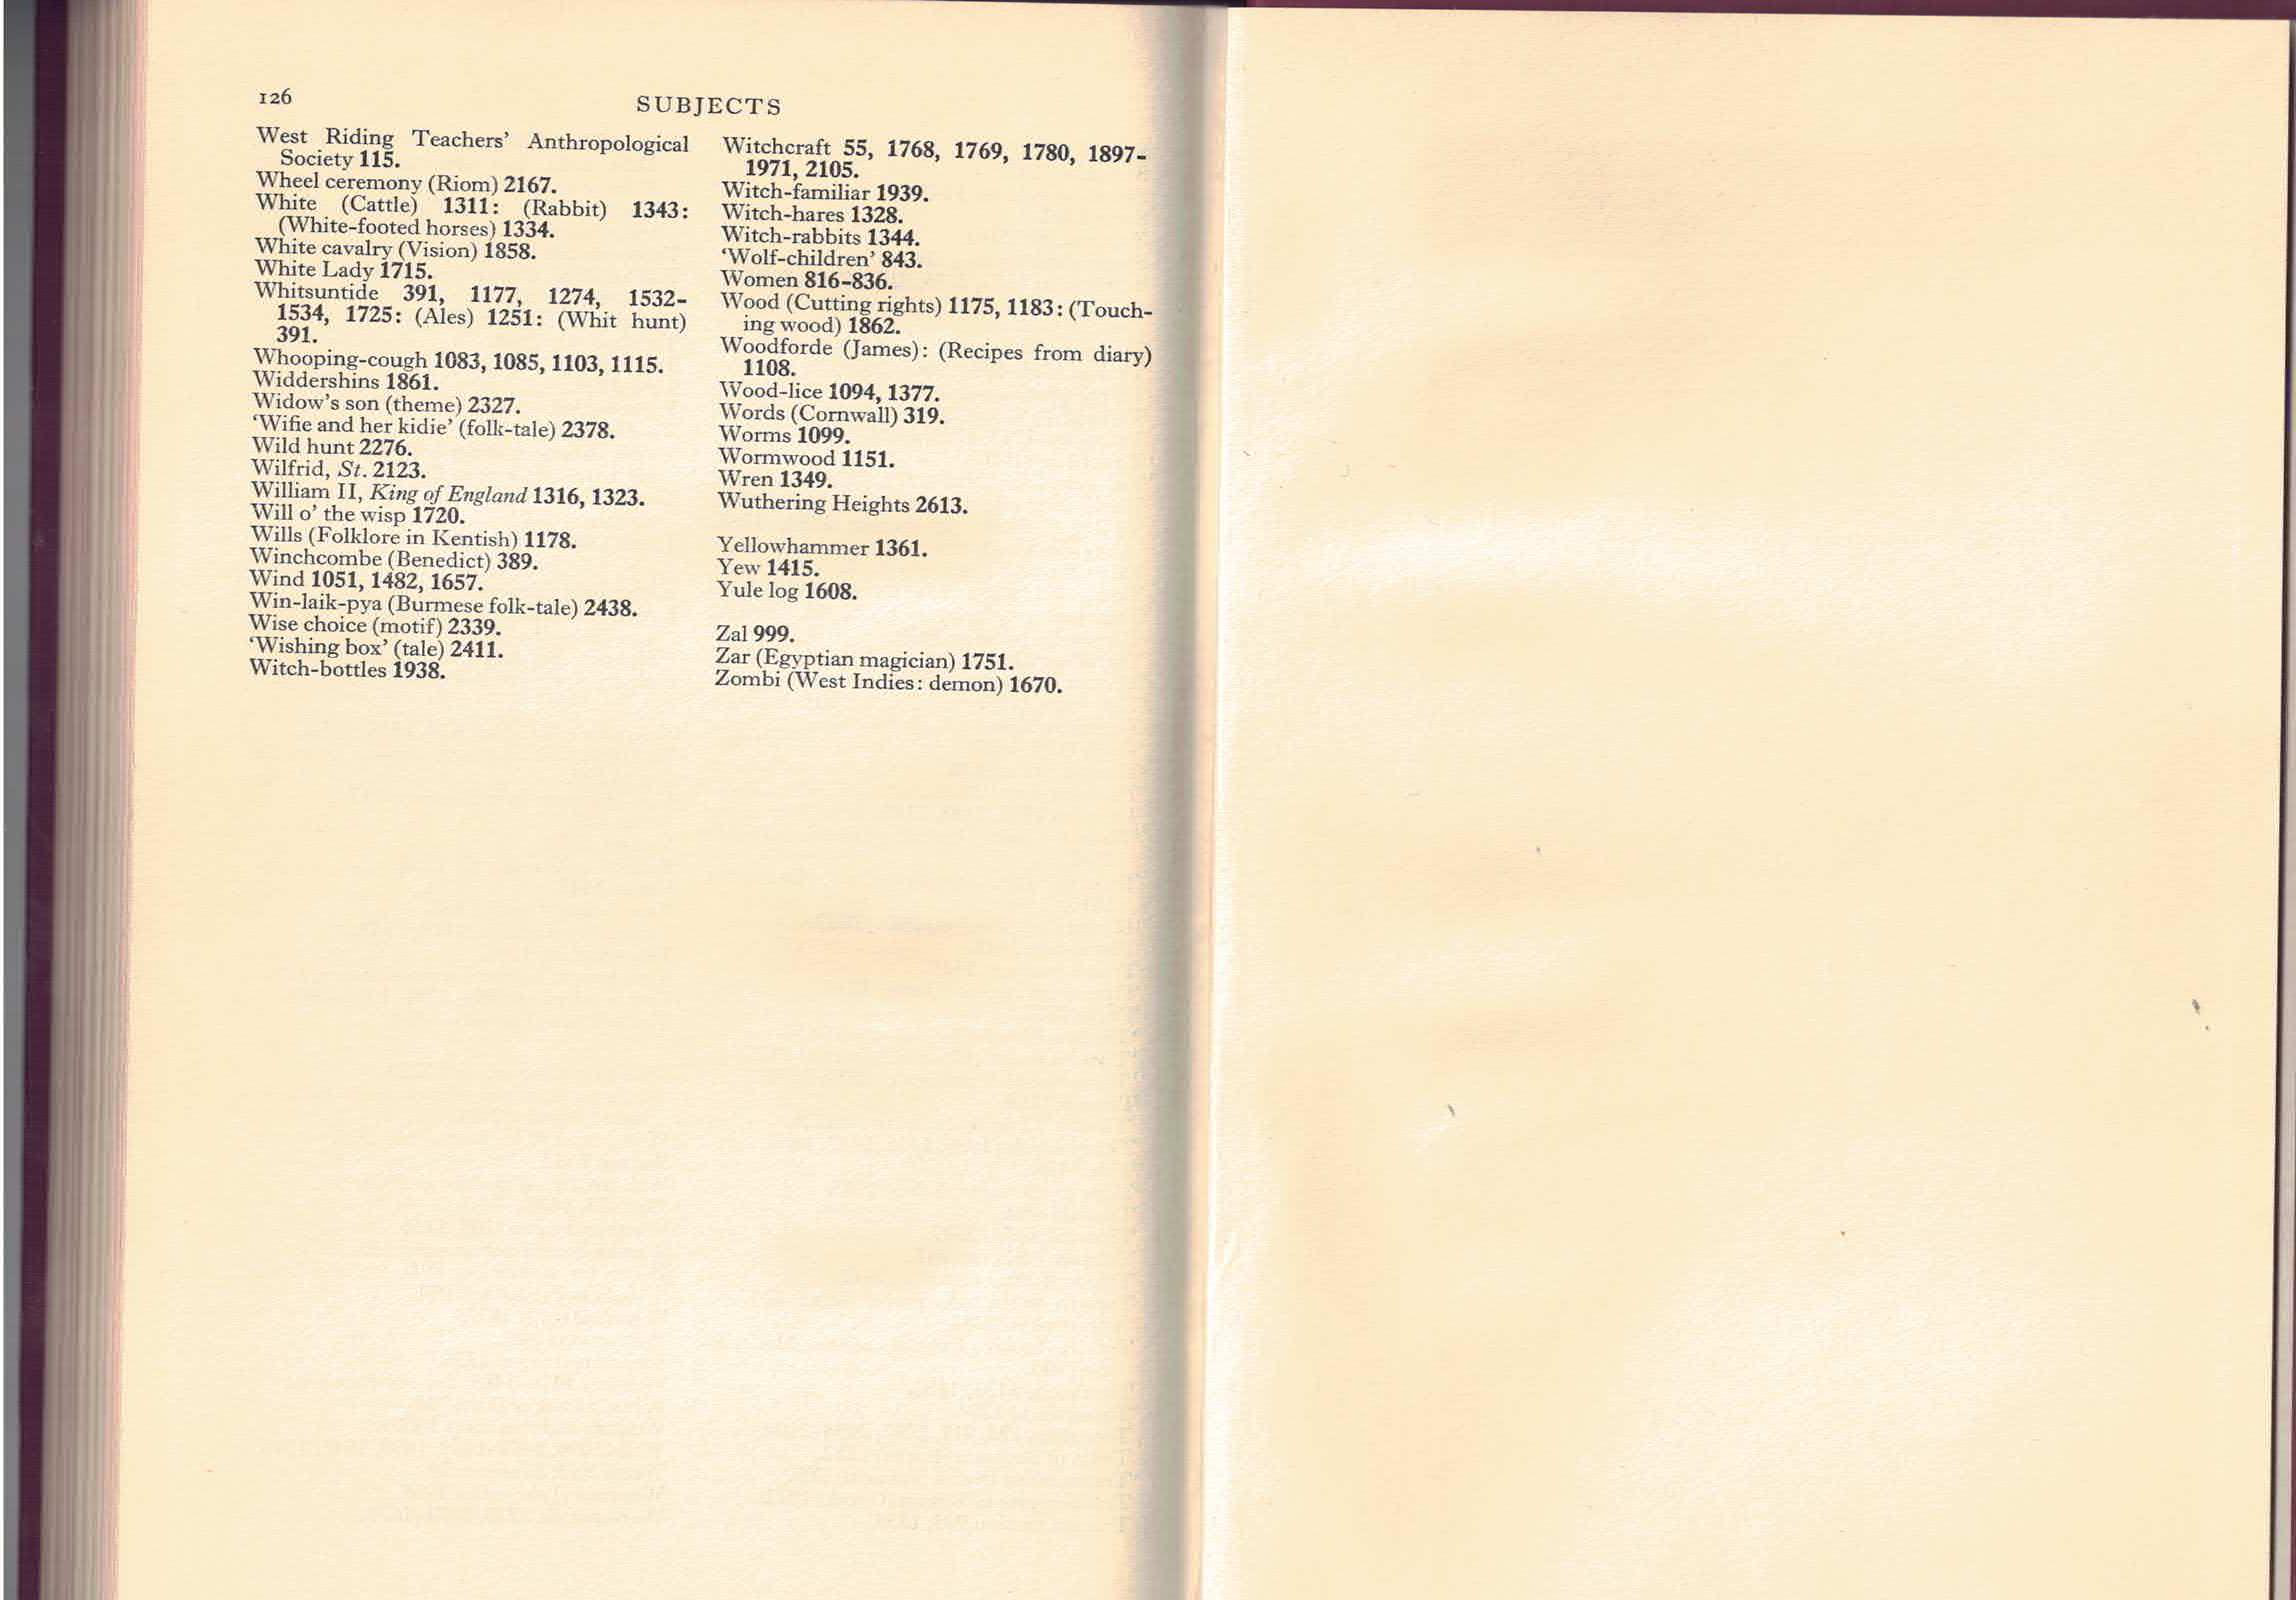

In [330]:
img

## Differencing

In [193]:
t1="""
At the risk pf exposing my "ignorance" still further, aud thereby causing additional surprise to the writer of the paper on the "Legends and Folklore of North Wales" in *Blackwood's Magazine*, I venture to reiterate my doubts as to the existence of the sin-eater in any part of Wales. Like every other country, the Principality had, and still has, her superstitions, but that of the sin-cater does not appear to be among them. Since the appearance of my former letter in the *Academy* (November 13), I have made all the enquiries I could into the subject, with the view of ascertaining whether such a personage has, or ever had, "a local habitation and a name" among us. I have spoken to many and correspondce with several persons who are known to have paid attention to the customs and traditions of the country; and the sum of their communications is, without any exception, that the superstition of the sin-eater was as novel to them as it was to me.

The writer points to Llandebie as the place where the custom prevailed as late as 1847, refers me for confirmation to a statement made by Mr. Matthew Moggridge at the annual meeting of the Cambrian Archaeological Association held at Ludlow in 1852, and is "surprised" that I, who became connected with the *A*rchaeologia Cambrensis* in 1872, should not be minutely acquainted with everything that appeared in that journal some twenty years previously. Whether I ever read the account of the Ludlow meeting I cannot say; but if I did, every trace of Mr. Moggridge's revelations had been effaced from my memory when I wrote my letter. The writer tells us that "at the meeting of the Cambrian archaeologists at Ludlow in 1852, Mr. Moggridge cited a case of this superstition as having occurred within five years at or near Llandebie, in the hill-country of Carmarthenshire." Mr. Moggridge said no such thing, and it is hardly fair to make him responsible for sentiments which he never expressed. The description of the sin-eater given by Mr. Moggridge is taken from Aubrey and the following are his words in reference to Llandebie, as reported in the *Archaeologia Cambrensis*, the organ of the Association:—

"In Carmarthenshire, not far from Llandebie, was a mountain valley, where, up to the commencement of the present century, the people were of a very lawless character. There the above practice was said to have prevailed to a recent period, and going thence to those parts of the county where, from the establishment of works, and from other causes, the people had more early become enlightened, he found the more absurd portions of the custom had been abandoned, while some still remained. Thus near Llanon, within twenty years, the plate, salt, and bread were retained; near Swansea (and, indeed, very generally), only the plate and salt."

Out of this statement the author of the article makes "five years"! and by that process brings the custom down to 1847. Mr. Moggridge, in a letter dated the first day of the present year, tells me that he does "not remember anything that gives a date," and adds that "the only written account" of the sin-eater "from personal knowledge" is that of Aubrey, 'de Gentilisme'". Aubrey, if I may rely on the extracts given in the *Academy*, does not say that he was eyewitness to the performances of the sin-eater in any part of Wales, and therefore, according to Mr. Moggridge, no one speaks of it from personal knowledge as having prevailed at any time in the Principality; and it will be borne in mind that I am writing of the Principality and not of the English counties.

Bat let us return to Llandebie, the locality in which it is asserted that the custom prevailed within the last thirty years. Mr. John Rowlands, a highly intelligent schoolmaster, author of a small volume of *Historical Notes* published about ten years ago, and at one time librarian to the late Sir Thomas Phillipps of Middle Hill, wrote to me on December 14 last in these words :—

"I opened the Llandebie School in the year 1850, and I lived there for many years. I knew all the parisioners, and the history of the parish; its legends, customs, and traditions. And during the time I was there I attended many funerals, but never heard of the 'sin-eater;' in fact people there never give cakes at funerals. I know almost every parish in South Wales; I collected all the legends, and made notes of the old customs for the late Sir Thomas Phillipps. If such a custom had prevailed I should have heard of it. I have no hesitation in writing that it is a glaring untruth."

Letters to the same effect appeared in the *Western Mail*, which circulates very extensively in the Principality, in the *Aberystwyth Observer*, and, I am told, in some other papers; but no one in reply has put in a plea in favour of the sin-eater.

The Rev. Rees Evans, vicar of Llandebie, has favoured me with the following letter in answer to my enquiries, and I must crave indulgence on the part of your readers for inserting it without abridgment:—

"I duly received your letter of the 22nd ult., which contained such extraordinary statements in reference to a superstitious custom supposed and alleged to be prevalent in this parish, viz., the employment at funerals of a strange person called the 'sin-eater.' I have been the vicar of this parish for the last fourteen years; and I have known this neighbourhood well for the last twenty-five years; but I never heard till I received your letter of such a personage as the 'sin-eater.' However, with the view of arriving at the truth or falsehood of the statements made by Mr. Moggridge at Ludlow in the year 1852, which appeared subsequently in the *Archaeologia Cambrensis*, and with the view of satisfying my own mind on the subject, I have during the last three weeks instituted searching enquiries in every part and hamlet of this parish, as to the probability of there having ever existed here such a functionary as 'sin-eater;' and the result of my investigation in the matter is this:- That such a custom as that alluded to in your letter never prevailed, at least for several centuries, in this parish and neighbourhood. That is the candid opinion of all classes of persons with whom I had long conversations while investigating the matter in question tor you. One intelligent old man, an octogenarian, whose ancestors had lived from time immemorial in this parish, told me that such a custom in his opinion, could not have prevailed here at least for the last two hundred years, or he would have heard of it from his father or his grandfather, who lived to a great age. Therefore, from all the enquiries that I have made, my candid opinion is that the statements which were made by Mr. Moggridge cannot be substantiated by any reliable authority or proved by any credible evidence."

Such are the results of my enquiries, and yet we are asked to believe that the sin-eater carried on his nefarious profession in the neighbourhood of Llandebie until within a little more than a quarter of a century.

The plate and salt mentioned by Mr. Moggridge as being still seen in some parts have no connection, or at least no necessary connexion, with the sin-eater, and much more satisfactory reasons are given for their employment. They are not uncommon, I understand, among Roman Catholics at the present day.

The whole story of the sin-eater appears to rest on the shoulders of Aubrey, and, as we have just seen, he does not state that he saw any performance of the custom among the Welsh people. Those who only retail his statements need not detain us. I leave it to others to judge what amount of credibility is due to so credulous a person as Aubrey in any case in which superstition plays a part. If we put implicit belief in what he says about the sin-eater, whether in England or out of England, I do not see how we can consistently refuse his evidence as to ghosts, spectres, witchcraft, and similar subjects, about which he is so eloquent.

In conclusion I would remark that if the custom under notice ever existed in Wales, it is somewhat strange if not "surprising," that the discovery of it has been exclusively confined to those who are ignorant of the language of the natives, and are but slightly acquainted with the country.
"""

t2 = """

The question between the writer in *Blackwood* and myself is a simple one, and I regret to find that in his letter in the *Academy* of to-day he mixes up with it a good deal of irrelevant matter, leaving the point at issue just where it was. He stated in his article that the custom of the sin-eater prevails in north and south Wales at the present day; when I challenged that statement and asked for proof, we were told that by the present day he means some thirty years ago; and when pressed for the locality he goes under the aegis of Mr. Moggridge to Llandebie "in the hill country of Carmarthenshire." When persons appeal to certain tribunals, they should not complain if they are sent to appear before the tribunals of their choice. Llandebie was named, and Llandebie was accepted: enquiries were made on the spot by competent persons; and those who will take the trouble to read my last letter will see with what success. The Sin-Eater is as little known there as probably he is in Nova Zembla. Now the writer shifts his ground and moves under the enlightening guidance of Murray's *Handbook for Travellers in South Wales*, to Cwm Amman, about seven miles from Llandebie. The compiler of that volume, whether ever "connected with Monmouthshire Iron Works" or not, states nothing about the Sin-Eater from personal knowledge of any informants, but quotes almost the identical words of Mr. Moggridge at Ludlow, with a slight variation as to the locality. Lady Verney, in the February number of the *Contemporary Review*, simply relates the same story over again, without any corroboration of her own. A false story does not become truth by repeti-tion, and these repetitions add nothing to our knowledge, and therefore it is simply waste of space to retail them.

The writer complains that I did not turn over a certain leaf in *Archaeologia Cambrensis*, where he intimates that Mr. Moggridge told the archaeologists at Ludlow that the practice of sin-eating was carried on at *Llandebie until five years of that time* (1852). The leaf had been turned over and read before I wrote my last letter; I turn it over again, and on it read the last utterances of Mr. Moggridge as follows:—

"Mr. Moggridge said— Far be it from him to desire that anything he should advance should not be combated, for all he wished to get at was truth. He thought that the gist of what fell from Mr. Allen was that there was no immediate connexion between the custom of Sin-Eater and the plate and the salt. Starting from the Carmarthenshire valley he found the most horrible portion of the custom dropped and the rest still retained; and as he advanced'still further he found that less remained. Mr. Aubrey, from whom he quoted, and who was a man of high character, said that the custom had existed both in Herefordshire and Shropshire. Mr. Aubrey told them he went to a cottage in Herefordshire, where he saw a man whom he described as the Sin-Eater; and he (Mr. Moggridge) found, in the very district where Mr. Aubrey had seen it in its most horrid perfection, that the more odious part of the custom had been removed, but portions thereof still remained. He thought that the plate and salt were of eastern origin. There was only one thing more that he need trouble them with, and that was whether the custom was extinct. He believed that people were thoroughly ashamed of the practice; one case, he was informed, occurred four or five years ago, but he believed it was extinct now."

These are Mr. Moggridge's last words at Ludlow, and I fail to find a syllable in them referring to Llandebie; and if he refers to any place, it must be, as I understand him, to some part of Herefordshire, with which the writer appears to me more acquainted than I can pretend to be, and to which, as I have already distinctly stated, my remarks do not apply. Mr Moggridge, and apparently the writer of the article, assume all along that the plate and salt are necessarily remnants of the alleged sin-eating practice and finding these articles employed in certain cases, they take it tor granted that the "more odious part of the custom has been removed," which amounts to begging the whole question. Mr. Moggridge candidly admits that he never witnessed tho "horrid custom" at Llandebie or elsewhere, but informs us that it "was said to have prevailed;" he does not mention his authorities, nor does he so much as hint what means his informants had of knowing the truth or untruth of the story. I can assure Mr. Moggridge that I mean no disrespect to him when I say that both the vicar and the schoolmaster have enjoyed more favourable opportunities than he is likely to have had of ascertaining the tacts of the case, on account of their connexion with the locality and their knowledge of their vernacular. I value Mr. Moggridge's opinions as opinions; but we are now in quest of facts; and opinions, from whatever source they may emanate, must not be mistaken for them. The question at issue lies within the domain of fact, and, therefore, capable of proof if the charge has any foundation on a more solid substance than "imagination all compact."

It is very kind, but slightly superfluous, on the part of the writer to "refresh" my memory respecting the various sin-bearing of the Levitical scapegoat." It is useless to argue about what may, could, or should have occurred, when we are concerned only with what has actually taken place. It is needless to expatiate on the possibility of a custom, when its existence is denied. The writer might have spared his sneering remark about the "treason" of calling Welshmen "ignorant" and "superstitions." The qualities denoted by these elegant stock-epithets, unfortunately, are not confined to the Principality of Wales; and one at least of these benighted barbarians holds that it is treason against truth to make charges that cannot be substantiated against any nation, however ignoraut or superstitious that nation may be. The writer seems to assume that it is a point of national honour," rather than any higher motive, that induces Welshmen to repudiate groundless imputations. When "national honour" and truth go together, "national honour" is not to be contemued.

The writer appears to feel rather uneasy on account of his incognito. He need not. It is perfectly immaterial whether he retains it or doffs it; but it shall not shield him from the consequences of making statements ot questionable authenticity. He vouchsafes to inform us that he is, "by parentage, ancestry, property, and interests, connected with two counties of South Wales" but he does not tell us that his ancestors ever furnished him with any information concerning the Sin-Eater, or that in his frequent visits to our benighted country he ever encountered that dread functionary. Sucn being the case, I confess to being a little hazy as to the relevance of long pedigrees and broad acres in two or more counties, fine things as they are, to the subject we are now discussing.. More to the point is the admission that, notwithstanding his frequent travels "over most of the Principality," he has "failed to acquire its language," that language being the very key to its customs, legends, and folk-lore. His travels, therefore, might resemble those of a blind man in quest of the beautiful.

If the writer *proves*, as he states in *Blackwood*, that the superstition of the Sin-Eater is "still surviving in North and South Wales," I shall at once confess my error, and the "national honour" shall take its chance; but if he fails to do this, he ought, in justice to the country of his "ancestry," to retract the groundless charge. He it is that has brought the accusation against it, and on him lies the burden of proof.
"""

In [200]:
from difflib import Differ, SequenceMatcher

seq = SequenceMatcher(None, t1, t2)

list(seq.get_matching_blocks())

[Match(a=0, b=0, size=1),
 Match(a=166, b=33, size=14),
 Match(a=191, b=47, size=1),
 Match(a=193, b=80, size=3),
 Match(a=461, b=109, size=25),
 Match(a=487, b=991, size=3),
 Match(a=500, b=1252, size=2),
 Match(a=505, b=1431, size=1),
 Match(a=566, b=1520, size=4),
 Match(a=621, b=1558, size=4),
 Match(a=670, b=1605, size=2),
 Match(a=682, b=1700, size=1),
 Match(a=953, b=1767, size=14),
 Match(a=976, b=1925, size=2),
 Match(a=1020, b=2002, size=1),
 Match(a=1199, b=2026, size=4),
 Match(a=1228, b=2078, size=2),
 Match(a=1338, b=2114, size=3),
 Match(a=1406, b=2165, size=2),
 Match(a=1505, b=2167, size=1),
 Match(a=2159, b=2187, size=5),
 Match(a=2166, b=2508, size=16),
 Match(a=2222, b=2524, size=7),
 Match(a=2306, b=2630, size=1),
 Match(a=2328, b=2678, size=2),
 Match(a=2330, b=3201, size=6),
 Match(a=2343, b=3316, size=2),
 Match(a=2369, b=3419, size=3),
 Match(a=2374, b=3444, size=2),
 Match(a=2800, b=3467, size=4),
 Match(a=2854, b=3813, size=1),
 Match(a=2857, b=4074, size=2),

In [202]:
t1[450:500], t2[100:150], 

('f my former letter in the *Academy* (November 13),',
 'at in his letter in the *Academy* of to-day he mix')

In [7]:
#!/usr/bin/python3

"""Diff Match and Patch
Copyright 2018 The diff-match-patch Authors.
https://github.com/google/diff-match-patch
https://raw.githubusercontent.com/google/diff-match-patch/master/python3/diff_match_patch.py

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

"""Functions for diff, match and patch.

Computes the difference between two texts to create a patch.
Applies the patch onto another text, allowing for errors.
"""

__author__ = 'fraser@google.com (Neil Fraser)'

import re
import sys
import time
import urllib.parse


class diff_match_patch:
  """Class containing the diff, match and patch methods.

  Also contains the behaviour settings.
  """

  def __init__(self):
    """Inits a diff_match_patch object with default settings.
    Redefine these in your program to override the defaults.
    """

    # Number of seconds to map a diff before giving up (0 for infinity).
    self.Diff_Timeout = 1.0
    # Cost of an empty edit operation in terms of edit characters.
    self.Diff_EditCost = 4
    # At what point is no match declared (0.0 = perfection, 1.0 = very loose).
    self.Match_Threshold = 0.5
    # How far to search for a match (0 = exact location, 1000+ = broad match).
    # A match this many characters away from the expected location will add
    # 1.0 to the score (0.0 is a perfect match).
    self.Match_Distance = 1000
    # When deleting a large block of text (over ~64 characters), how close do
    # the contents have to be to match the expected contents. (0.0 = perfection,
    # 1.0 = very loose).  Note that Match_Threshold controls how closely the
    # end points of a delete need to match.
    self.Patch_DeleteThreshold = 0.5
    # Chunk size for context length.
    self.Patch_Margin = 4

    # The number of bits in an int.
    # Python has no maximum, thus to disable patch splitting set to 0.
    # However to avoid long patches in certain pathological cases, use 32.
    # Multiple short patches (using native ints) are much faster than long ones.
    self.Match_MaxBits = 32

  #  DIFF FUNCTIONS

  # The data structure representing a diff is an array of tuples:
  # [(DIFF_DELETE, "Hello"), (DIFF_INSERT, "Goodbye"), (DIFF_EQUAL, " world.")]
  # which means: delete "Hello", add "Goodbye" and keep " world."
  DIFF_DELETE = -1
  DIFF_INSERT = 1
  DIFF_EQUAL = 0

  def diff_main(self, text1, text2, checklines=True, deadline=None):
    """Find the differences between two texts.  Simplifies the problem by
      stripping any common prefix or suffix off the texts before diffing.

    Args:
      text1: Old string to be diffed.
      text2: New string to be diffed.
      checklines: Optional speedup flag.  If present and false, then don't run
        a line-level diff first to identify the changed areas.
        Defaults to true, which does a faster, slightly less optimal diff.
      deadline: Optional time when the diff should be complete by.  Used
        internally for recursive calls.  Users should set DiffTimeout instead.

    Returns:
      Array of changes.
    """
    # Set a deadline by which time the diff must be complete.
    if deadline == None:
      # Unlike in most languages, Python counts time in seconds.
      if self.Diff_Timeout <= 0:
        deadline = sys.maxsize
      else:
        deadline = time.time() + self.Diff_Timeout

    # Check for null inputs.
    if text1 == None or text2 == None:
      raise ValueError("Null inputs. (diff_main)")

    # Check for equality (speedup).
    if text1 == text2:
      if text1:
        return [(self.DIFF_EQUAL, text1)]
      return []

    # Trim off common prefix (speedup).
    commonlength = self.diff_commonPrefix(text1, text2)
    commonprefix = text1[:commonlength]
    text1 = text1[commonlength:]
    text2 = text2[commonlength:]

    # Trim off common suffix (speedup).
    commonlength = self.diff_commonSuffix(text1, text2)
    if commonlength == 0:
      commonsuffix = ''
    else:
      commonsuffix = text1[-commonlength:]
      text1 = text1[:-commonlength]
      text2 = text2[:-commonlength]

    # Compute the diff on the middle block.
    diffs = self.diff_compute(text1, text2, checklines, deadline)

    # Restore the prefix and suffix.
    if commonprefix:
      diffs[:0] = [(self.DIFF_EQUAL, commonprefix)]
    if commonsuffix:
      diffs.append((self.DIFF_EQUAL, commonsuffix))
    self.diff_cleanupMerge(diffs)
    return diffs

  def diff_compute(self, text1, text2, checklines, deadline):
    """Find the differences between two texts.  Assumes that the texts do not
      have any common prefix or suffix.

    Args:
      text1: Old string to be diffed.
      text2: New string to be diffed.
      checklines: Speedup flag.  If false, then don't run a line-level diff
        first to identify the changed areas.
        If true, then run a faster, slightly less optimal diff.
      deadline: Time when the diff should be complete by.

    Returns:
      Array of changes.
    """
    if not text1:
      # Just add some text (speedup).
      return [(self.DIFF_INSERT, text2)]

    if not text2:
      # Just delete some text (speedup).
      return [(self.DIFF_DELETE, text1)]

    if len(text1) > len(text2):
      (longtext, shorttext) = (text1, text2)
    else:
      (shorttext, longtext) = (text1, text2)
    i = longtext.find(shorttext)
    if i != -1:
      # Shorter text is inside the longer text (speedup).
      diffs = [(self.DIFF_INSERT, longtext[:i]), (self.DIFF_EQUAL, shorttext),
               (self.DIFF_INSERT, longtext[i + len(shorttext):])]
      # Swap insertions for deletions if diff is reversed.
      if len(text1) > len(text2):
        diffs[0] = (self.DIFF_DELETE, diffs[0][1])
        diffs[2] = (self.DIFF_DELETE, diffs[2][1])
      return diffs

    if len(shorttext) == 1:
      # Single character string.
      # After the previous speedup, the character can't be an equality.
      return [(self.DIFF_DELETE, text1), (self.DIFF_INSERT, text2)]

    # Check to see if the problem can be split in two.
    hm = self.diff_halfMatch(text1, text2)
    if hm:
      # A half-match was found, sort out the return data.
      (text1_a, text1_b, text2_a, text2_b, mid_common) = hm
      # Send both pairs off for separate processing.
      diffs_a = self.diff_main(text1_a, text2_a, checklines, deadline)
      diffs_b = self.diff_main(text1_b, text2_b, checklines, deadline)
      # Merge the results.
      return diffs_a + [(self.DIFF_EQUAL, mid_common)] + diffs_b

    if checklines and len(text1) > 100 and len(text2) > 100:
      return self.diff_lineMode(text1, text2, deadline)

    return self.diff_bisect(text1, text2, deadline)

  def diff_lineMode(self, text1, text2, deadline):
    """Do a quick line-level diff on both strings, then rediff the parts for
      greater accuracy.
      This speedup can produce non-minimal diffs.

    Args:
      text1: Old string to be diffed.
      text2: New string to be diffed.
      deadline: Time when the diff should be complete by.

    Returns:
      Array of changes.
    """

    # Scan the text on a line-by-line basis first.
    (text1, text2, linearray) = self.diff_linesToChars(text1, text2)

    diffs = self.diff_main(text1, text2, False, deadline)

    # Convert the diff back to original text.
    self.diff_charsToLines(diffs, linearray)
    # Eliminate freak matches (e.g. blank lines)
    self.diff_cleanupSemantic(diffs)

    # Rediff any replacement blocks, this time character-by-character.
    # Add a dummy entry at the end.
    diffs.append((self.DIFF_EQUAL, ''))
    pointer = 0
    count_delete = 0
    count_insert = 0
    text_delete = ''
    text_insert = ''
    while pointer < len(diffs):
      if diffs[pointer][0] == self.DIFF_INSERT:
        count_insert += 1
        text_insert += diffs[pointer][1]
      elif diffs[pointer][0] == self.DIFF_DELETE:
        count_delete += 1
        text_delete += diffs[pointer][1]
      elif diffs[pointer][0] == self.DIFF_EQUAL:
        # Upon reaching an equality, check for prior redundancies.
        if count_delete >= 1 and count_insert >= 1:
          # Delete the offending records and add the merged ones.
          subDiff = self.diff_main(text_delete, text_insert, False, deadline)
          diffs[pointer - count_delete - count_insert: pointer] = subDiff
          pointer = pointer - count_delete - count_insert + len(subDiff)
        count_insert = 0
        count_delete = 0
        text_delete = ''
        text_insert = ''

      pointer += 1

    diffs.pop()  # Remove the dummy entry at the end.

    return diffs

  def diff_bisect(self, text1, text2, deadline):
    """Find the 'middle snake' of a diff, split the problem in two
      and return the recursively constructed diff.
      See Myers 1986 paper: An O(ND) Difference Algorithm and Its Variations.

    Args:
      text1: Old string to be diffed.
      text2: New string to be diffed.
      deadline: Time at which to bail if not yet complete.

    Returns:
      Array of diff tuples.
    """

    # Cache the text lengths to prevent multiple calls.
    text1_length = len(text1)
    text2_length = len(text2)
    max_d = (text1_length + text2_length + 1) // 2
    v_offset = max_d
    v_length = 2 * max_d
    v1 = [-1] * v_length
    v1[v_offset + 1] = 0
    v2 = v1[:]
    delta = text1_length - text2_length
    # If the total number of characters is odd, then the front path will
    # collide with the reverse path.
    front = (delta % 2 != 0)
    # Offsets for start and end of k loop.
    # Prevents mapping of space beyond the grid.
    k1start = 0
    k1end = 0
    k2start = 0
    k2end = 0
    for d in range(max_d):
      # Bail out if deadline is reached.
      if time.time() > deadline:
        break

      # Walk the front path one step.
      for k1 in range(-d + k1start, d + 1 - k1end, 2):
        k1_offset = v_offset + k1
        if k1 == -d or (k1 != d and
            v1[k1_offset - 1] < v1[k1_offset + 1]):
          x1 = v1[k1_offset + 1]
        else:
          x1 = v1[k1_offset - 1] + 1
        y1 = x1 - k1
        while (x1 < text1_length and y1 < text2_length and
               text1[x1] == text2[y1]):
          x1 += 1
          y1 += 1
        v1[k1_offset] = x1
        if x1 > text1_length:
          # Ran off the right of the graph.
          k1end += 2
        elif y1 > text2_length:
          # Ran off the bottom of the graph.
          k1start += 2
        elif front:
          k2_offset = v_offset + delta - k1
          if k2_offset >= 0 and k2_offset < v_length and v2[k2_offset] != -1:
            # Mirror x2 onto top-left coordinate system.
            x2 = text1_length - v2[k2_offset]
            if x1 >= x2:
              # Overlap detected.
              return self.diff_bisectSplit(text1, text2, x1, y1, deadline)

      # Walk the reverse path one step.
      for k2 in range(-d + k2start, d + 1 - k2end, 2):
        k2_offset = v_offset + k2
        if k2 == -d or (k2 != d and
            v2[k2_offset - 1] < v2[k2_offset + 1]):
          x2 = v2[k2_offset + 1]
        else:
          x2 = v2[k2_offset - 1] + 1
        y2 = x2 - k2
        while (x2 < text1_length and y2 < text2_length and
               text1[-x2 - 1] == text2[-y2 - 1]):
          x2 += 1
          y2 += 1
        v2[k2_offset] = x2
        if x2 > text1_length:
          # Ran off the left of the graph.
          k2end += 2
        elif y2 > text2_length:
          # Ran off the top of the graph.
          k2start += 2
        elif not front:
          k1_offset = v_offset + delta - k2
          if k1_offset >= 0 and k1_offset < v_length and v1[k1_offset] != -1:
            x1 = v1[k1_offset]
            y1 = v_offset + x1 - k1_offset
            # Mirror x2 onto top-left coordinate system.
            x2 = text1_length - x2
            if x1 >= x2:
              # Overlap detected.
              return self.diff_bisectSplit(text1, text2, x1, y1, deadline)

    # Diff took too long and hit the deadline or
    # number of diffs equals number of characters, no commonality at all.
    return [(self.DIFF_DELETE, text1), (self.DIFF_INSERT, text2)]

  def diff_bisectSplit(self, text1, text2, x, y, deadline):
    """Given the location of the 'middle snake', split the diff in two parts
    and recurse.

    Args:
      text1: Old string to be diffed.
      text2: New string to be diffed.
      x: Index of split point in text1.
      y: Index of split point in text2.
      deadline: Time at which to bail if not yet complete.

    Returns:
      Array of diff tuples.
    """
    text1a = text1[:x]
    text2a = text2[:y]
    text1b = text1[x:]
    text2b = text2[y:]

    # Compute both diffs serially.
    diffs = self.diff_main(text1a, text2a, False, deadline)
    diffsb = self.diff_main(text1b, text2b, False, deadline)

    return diffs + diffsb

  def diff_linesToChars(self, text1, text2):
    """Split two texts into an array of strings.  Reduce the texts to a string
    of hashes where each Unicode character represents one line.

    Args:
      text1: First string.
      text2: Second string.

    Returns:
      Three element tuple, containing the encoded text1, the encoded text2 and
      the array of unique strings.  The zeroth element of the array of unique
      strings is intentionally blank.
    """
    lineArray = []  # e.g. lineArray[4] == "Hello\n"
    lineHash = {}   # e.g. lineHash["Hello\n"] == 4

    # "\x00" is a valid character, but various debuggers don't like it.
    # So we'll insert a junk entry to avoid generating a null character.
    lineArray.append('')

    def diff_linesToCharsMunge(text):
      """Split a text into an array of strings.  Reduce the texts to a string
      of hashes where each Unicode character represents one line.
      Modifies linearray and linehash through being a closure.

      Args:
        text: String to encode.

      Returns:
        Encoded string.
      """
      chars = []
      # Walk the text, pulling out a substring for each line.
      # text.split('\n') would would temporarily double our memory footprint.
      # Modifying text would create many large strings to garbage collect.
      lineStart = 0
      lineEnd = -1
      while lineEnd < len(text) - 1:
        lineEnd = text.find('\n', lineStart)
        if lineEnd == -1:
          lineEnd = len(text) - 1
        line = text[lineStart:lineEnd + 1]

        if line in lineHash:
          chars.append(chr(lineHash[line]))
        else:
          if len(lineArray) == maxLines:
            # Bail out at 1114111 because chr(1114112) throws.
            line = text[lineStart:]
            lineEnd = len(text)
          lineArray.append(line)
          lineHash[line] = len(lineArray) - 1
          chars.append(chr(len(lineArray) - 1))
        lineStart = lineEnd + 1
      return "".join(chars)

    # Allocate 2/3rds of the space for text1, the rest for text2.
    maxLines = 666666
    chars1 = diff_linesToCharsMunge(text1)
    maxLines = 1114111
    chars2 = diff_linesToCharsMunge(text2)
    return (chars1, chars2, lineArray)

  def diff_charsToLines(self, diffs, lineArray):
    """Rehydrate the text in a diff from a string of line hashes to real lines
    of text.

    Args:
      diffs: Array of diff tuples.
      lineArray: Array of unique strings.
    """
    for i in range(len(diffs)):
      text = []
      for char in diffs[i][1]:
        text.append(lineArray[ord(char)])
      diffs[i] = (diffs[i][0], "".join(text))

  def diff_commonPrefix(self, text1, text2):
    """Determine the common prefix of two strings.

    Args:
      text1: First string.
      text2: Second string.

    Returns:
      The number of characters common to the start of each string.
    """
    # Quick check for common null cases.
    if not text1 or not text2 or text1[0] != text2[0]:
      return 0
    # Binary search.
    # Performance analysis: https://neil.fraser.name/news/2007/10/09/
    pointermin = 0
    pointermax = min(len(text1), len(text2))
    pointermid = pointermax
    pointerstart = 0
    while pointermin < pointermid:
      if text1[pointerstart:pointermid] == text2[pointerstart:pointermid]:
        pointermin = pointermid
        pointerstart = pointermin
      else:
        pointermax = pointermid
      pointermid = (pointermax - pointermin) // 2 + pointermin
    return pointermid

  def diff_commonSuffix(self, text1, text2):
    """Determine the common suffix of two strings.

    Args:
      text1: First string.
      text2: Second string.

    Returns:
      The number of characters common to the end of each string.
    """
    # Quick check for common null cases.
    if not text1 or not text2 or text1[-1] != text2[-1]:
      return 0
    # Binary search.
    # Performance analysis: https://neil.fraser.name/news/2007/10/09/
    pointermin = 0
    pointermax = min(len(text1), len(text2))
    pointermid = pointermax
    pointerend = 0
    while pointermin < pointermid:
      if (text1[-pointermid:len(text1) - pointerend] ==
          text2[-pointermid:len(text2) - pointerend]):
        pointermin = pointermid
        pointerend = pointermin
      else:
        pointermax = pointermid
      pointermid = (pointermax - pointermin) // 2 + pointermin
    return pointermid

  def diff_commonOverlap(self, text1, text2):
    """Determine if the suffix of one string is the prefix of another.

    Args:
      text1 First string.
      text2 Second string.

    Returns:
      The number of characters common to the end of the first
      string and the start of the second string.
    """
    # Cache the text lengths to prevent multiple calls.
    text1_length = len(text1)
    text2_length = len(text2)
    # Eliminate the null case.
    if text1_length == 0 or text2_length == 0:
      return 0
    # Truncate the longer string.
    if text1_length > text2_length:
      text1 = text1[-text2_length:]
    elif text1_length < text2_length:
      text2 = text2[:text1_length]
    text_length = min(text1_length, text2_length)
    # Quick check for the worst case.
    if text1 == text2:
      return text_length

    # Start by looking for a single character match
    # and increase length until no match is found.
    # Performance analysis: https://neil.fraser.name/news/2010/11/04/
    best = 0
    length = 1
    while True:
      pattern = text1[-length:]
      found = text2.find(pattern)
      if found == -1:
        return best
      length += found
      if found == 0 or text1[-length:] == text2[:length]:
        best = length
        length += 1

  def diff_halfMatch(self, text1, text2):
    """Do the two texts share a substring which is at least half the length of
    the longer text?
    This speedup can produce non-minimal diffs.

    Args:
      text1: First string.
      text2: Second string.

    Returns:
      Five element Array, containing the prefix of text1, the suffix of text1,
      the prefix of text2, the suffix of text2 and the common middle.  Or None
      if there was no match.
    """
    if self.Diff_Timeout <= 0:
      # Don't risk returning a non-optimal diff if we have unlimited time.
      return None
    if len(text1) > len(text2):
      (longtext, shorttext) = (text1, text2)
    else:
      (shorttext, longtext) = (text1, text2)
    if len(longtext) < 4 or len(shorttext) * 2 < len(longtext):
      return None  # Pointless.

    def diff_halfMatchI(longtext, shorttext, i):
      """Does a substring of shorttext exist within longtext such that the
      substring is at least half the length of longtext?
      Closure, but does not reference any external variables.

      Args:
        longtext: Longer string.
        shorttext: Shorter string.
        i: Start index of quarter length substring within longtext.

      Returns:
        Five element Array, containing the prefix of longtext, the suffix of
        longtext, the prefix of shorttext, the suffix of shorttext and the
        common middle.  Or None if there was no match.
      """
      seed = longtext[i:i + len(longtext) // 4]
      best_common = ''
      j = shorttext.find(seed)
      while j != -1:
        prefixLength = self.diff_commonPrefix(longtext[i:], shorttext[j:])
        suffixLength = self.diff_commonSuffix(longtext[:i], shorttext[:j])
        if len(best_common) < suffixLength + prefixLength:
          best_common = (shorttext[j - suffixLength:j] +
              shorttext[j:j + prefixLength])
          best_longtext_a = longtext[:i - suffixLength]
          best_longtext_b = longtext[i + prefixLength:]
          best_shorttext_a = shorttext[:j - suffixLength]
          best_shorttext_b = shorttext[j + prefixLength:]
        j = shorttext.find(seed, j + 1)

      if len(best_common) * 2 >= len(longtext):
        return (best_longtext_a, best_longtext_b,
                best_shorttext_a, best_shorttext_b, best_common)
      else:
        return None

    # First check if the second quarter is the seed for a half-match.
    hm1 = diff_halfMatchI(longtext, shorttext, (len(longtext) + 3) // 4)
    # Check again based on the third quarter.
    hm2 = diff_halfMatchI(longtext, shorttext, (len(longtext) + 1) // 2)
    if not hm1 and not hm2:
      return None
    elif not hm2:
      hm = hm1
    elif not hm1:
      hm = hm2
    else:
      # Both matched.  Select the longest.
      if len(hm1[4]) > len(hm2[4]):
        hm = hm1
      else:
        hm = hm2

    # A half-match was found, sort out the return data.
    if len(text1) > len(text2):
      (text1_a, text1_b, text2_a, text2_b, mid_common) = hm
    else:
      (text2_a, text2_b, text1_a, text1_b, mid_common) = hm
    return (text1_a, text1_b, text2_a, text2_b, mid_common)

  def diff_cleanupSemantic(self, diffs):
    """Reduce the number of edits by eliminating semantically trivial
    equalities.

    Args:
      diffs: Array of diff tuples.
    """
    changes = False
    equalities = []  # Stack of indices where equalities are found.
    lastEquality = None  # Always equal to diffs[equalities[-1]][1]
    pointer = 0  # Index of current position.
    # Number of chars that changed prior to the equality.
    length_insertions1, length_deletions1 = 0, 0
    # Number of chars that changed after the equality.
    length_insertions2, length_deletions2 = 0, 0
    while pointer < len(diffs):
      if diffs[pointer][0] == self.DIFF_EQUAL:  # Equality found.
        equalities.append(pointer)
        length_insertions1, length_insertions2 = length_insertions2, 0
        length_deletions1, length_deletions2 = length_deletions2, 0
        lastEquality = diffs[pointer][1]
      else:  # An insertion or deletion.
        if diffs[pointer][0] == self.DIFF_INSERT:
          length_insertions2 += len(diffs[pointer][1])
        else:
          length_deletions2 += len(diffs[pointer][1])
        # Eliminate an equality that is smaller or equal to the edits on both
        # sides of it.
        if (lastEquality and (len(lastEquality) <=
            max(length_insertions1, length_deletions1)) and
            (len(lastEquality) <= max(length_insertions2, length_deletions2))):
          # Duplicate record.
          diffs.insert(equalities[-1], (self.DIFF_DELETE, lastEquality))
          # Change second copy to insert.
          diffs[equalities[-1] + 1] = (self.DIFF_INSERT,
              diffs[equalities[-1] + 1][1])
          # Throw away the equality we just deleted.
          equalities.pop()
          # Throw away the previous equality (it needs to be reevaluated).
          if len(equalities):
            equalities.pop()
          if len(equalities):
            pointer = equalities[-1]
          else:
            pointer = -1
          # Reset the counters.
          length_insertions1, length_deletions1 = 0, 0
          length_insertions2, length_deletions2 = 0, 0
          lastEquality = None
          changes = True
      pointer += 1

    # Normalize the diff.
    if changes:
      self.diff_cleanupMerge(diffs)
    self.diff_cleanupSemanticLossless(diffs)

    # Find any overlaps between deletions and insertions.
    # e.g: <del>abcxxx</del><ins>xxxdef</ins>
    #   -> <del>abc</del>xxx<ins>def</ins>
    # e.g: <del>xxxabc</del><ins>defxxx</ins>
    #   -> <ins>def</ins>xxx<del>abc</del>
    # Only extract an overlap if it is as big as the edit ahead or behind it.
    pointer = 1
    while pointer < len(diffs):
      if (diffs[pointer - 1][0] == self.DIFF_DELETE and
          diffs[pointer][0] == self.DIFF_INSERT):
        deletion = diffs[pointer - 1][1]
        insertion = diffs[pointer][1]
        overlap_length1 = self.diff_commonOverlap(deletion, insertion)
        overlap_length2 = self.diff_commonOverlap(insertion, deletion)
        if overlap_length1 >= overlap_length2:
          if (overlap_length1 >= len(deletion) / 2.0 or
              overlap_length1 >= len(insertion) / 2.0):
            # Overlap found.  Insert an equality and trim the surrounding edits.
            diffs.insert(pointer, (self.DIFF_EQUAL,
                                   insertion[:overlap_length1]))
            diffs[pointer - 1] = (self.DIFF_DELETE,
                                  deletion[:len(deletion) - overlap_length1])
            diffs[pointer + 1] = (self.DIFF_INSERT,
                                  insertion[overlap_length1:])
            pointer += 1
        else:
          if (overlap_length2 >= len(deletion) / 2.0 or
              overlap_length2 >= len(insertion) / 2.0):
            # Reverse overlap found.
            # Insert an equality and swap and trim the surrounding edits.
            diffs.insert(pointer, (self.DIFF_EQUAL, deletion[:overlap_length2]))
            diffs[pointer - 1] = (self.DIFF_INSERT,
                                  insertion[:len(insertion) - overlap_length2])
            diffs[pointer + 1] = (self.DIFF_DELETE, deletion[overlap_length2:])
            pointer += 1
        pointer += 1
      pointer += 1

  def diff_cleanupSemanticLossless(self, diffs):
    """Look for single edits surrounded on both sides by equalities
    which can be shifted sideways to align the edit to a word boundary.
    e.g: The c<ins>at c</ins>ame. -> The <ins>cat </ins>came.

    Args:
      diffs: Array of diff tuples.
    """

    def diff_cleanupSemanticScore(one, two):
      """Given two strings, compute a score representing whether the
      internal boundary falls on logical boundaries.
      Scores range from 6 (best) to 0 (worst).
      Closure, but does not reference any external variables.

      Args:
        one: First string.
        two: Second string.

      Returns:
        The score.
      """
      if not one or not two:
        # Edges are the best.
        return 6

      # Each port of this function behaves slightly differently due to
      # subtle differences in each language's definition of things like
      # 'whitespace'.  Since this function's purpose is largely cosmetic,
      # the choice has been made to use each language's native features
      # rather than force total conformity.
      char1 = one[-1]
      char2 = two[0]
      nonAlphaNumeric1 = not char1.isalnum()
      nonAlphaNumeric2 = not char2.isalnum()
      whitespace1 = nonAlphaNumeric1 and char1.isspace()
      whitespace2 = nonAlphaNumeric2 and char2.isspace()
      lineBreak1 = whitespace1 and (char1 == "\r" or char1 == "\n")
      lineBreak2 = whitespace2 and (char2 == "\r" or char2 == "\n")
      blankLine1 = lineBreak1 and self.BLANKLINEEND.search(one)
      blankLine2 = lineBreak2 and self.BLANKLINESTART.match(two)

      if blankLine1 or blankLine2:
        # Five points for blank lines.
        return 5
      elif lineBreak1 or lineBreak2:
        # Four points for line breaks.
        return 4
      elif nonAlphaNumeric1 and not whitespace1 and whitespace2:
        # Three points for end of sentences.
        return 3
      elif whitespace1 or whitespace2:
        # Two points for whitespace.
        return 2
      elif nonAlphaNumeric1 or nonAlphaNumeric2:
        # One point for non-alphanumeric.
        return 1
      return 0

    pointer = 1
    # Intentionally ignore the first and last element (don't need checking).
    while pointer < len(diffs) - 1:
      if (diffs[pointer - 1][0] == self.DIFF_EQUAL and
          diffs[pointer + 1][0] == self.DIFF_EQUAL):
        # This is a single edit surrounded by equalities.
        equality1 = diffs[pointer - 1][1]
        edit = diffs[pointer][1]
        equality2 = diffs[pointer + 1][1]

        # First, shift the edit as far left as possible.
        commonOffset = self.diff_commonSuffix(equality1, edit)
        if commonOffset:
          commonString = edit[-commonOffset:]
          equality1 = equality1[:-commonOffset]
          edit = commonString + edit[:-commonOffset]
          equality2 = commonString + equality2

        # Second, step character by character right, looking for the best fit.
        bestEquality1 = equality1
        bestEdit = edit
        bestEquality2 = equality2
        bestScore = (diff_cleanupSemanticScore(equality1, edit) +
            diff_cleanupSemanticScore(edit, equality2))
        while edit and equality2 and edit[0] == equality2[0]:
          equality1 += edit[0]
          edit = edit[1:] + equality2[0]
          equality2 = equality2[1:]
          score = (diff_cleanupSemanticScore(equality1, edit) +
              diff_cleanupSemanticScore(edit, equality2))
          # The >= encourages trailing rather than leading whitespace on edits.
          if score >= bestScore:
            bestScore = score
            bestEquality1 = equality1
            bestEdit = edit
            bestEquality2 = equality2

        if diffs[pointer - 1][1] != bestEquality1:
          # We have an improvement, save it back to the diff.
          if bestEquality1:
            diffs[pointer - 1] = (diffs[pointer - 1][0], bestEquality1)
          else:
            del diffs[pointer - 1]
            pointer -= 1
          diffs[pointer] = (diffs[pointer][0], bestEdit)
          if bestEquality2:
            diffs[pointer + 1] = (diffs[pointer + 1][0], bestEquality2)
          else:
            del diffs[pointer + 1]
            pointer -= 1
      pointer += 1

  # Define some regex patterns for matching boundaries.
  BLANKLINEEND = re.compile(r"\n\r?\n$")
  BLANKLINESTART = re.compile(r"^\r?\n\r?\n")

  def diff_cleanupEfficiency(self, diffs):
    """Reduce the number of edits by eliminating operationally trivial
    equalities.

    Args:
      diffs: Array of diff tuples.
    """
    changes = False
    equalities = []  # Stack of indices where equalities are found.
    lastEquality = None  # Always equal to diffs[equalities[-1]][1]
    pointer = 0  # Index of current position.
    pre_ins = False  # Is there an insertion operation before the last equality.
    pre_del = False  # Is there a deletion operation before the last equality.
    post_ins = False  # Is there an insertion operation after the last equality.
    post_del = False  # Is there a deletion operation after the last equality.
    while pointer < len(diffs):
      if diffs[pointer][0] == self.DIFF_EQUAL:  # Equality found.
        if (len(diffs[pointer][1]) < self.Diff_EditCost and
            (post_ins or post_del)):
          # Candidate found.
          equalities.append(pointer)
          pre_ins = post_ins
          pre_del = post_del
          lastEquality = diffs[pointer][1]
        else:
          # Not a candidate, and can never become one.
          equalities = []
          lastEquality = None

        post_ins = post_del = False
      else:  # An insertion or deletion.
        if diffs[pointer][0] == self.DIFF_DELETE:
          post_del = True
        else:
          post_ins = True

        # Five types to be split:
        # <ins>A</ins><del>B</del>XY<ins>C</ins><del>D</del>
        # <ins>A</ins>X<ins>C</ins><del>D</del>
        # <ins>A</ins><del>B</del>X<ins>C</ins>
        # <ins>A</del>X<ins>C</ins><del>D</del>
        # <ins>A</ins><del>B</del>X<del>C</del>

        if lastEquality and ((pre_ins and pre_del and post_ins and post_del) or
                             ((len(lastEquality) < self.Diff_EditCost / 2) and
                              (pre_ins + pre_del + post_ins + post_del) == 3)):
          # Duplicate record.
          diffs.insert(equalities[-1], (self.DIFF_DELETE, lastEquality))
          # Change second copy to insert.
          diffs[equalities[-1] + 1] = (self.DIFF_INSERT,
              diffs[equalities[-1] + 1][1])
          equalities.pop()  # Throw away the equality we just deleted.
          lastEquality = None
          if pre_ins and pre_del:
            # No changes made which could affect previous entry, keep going.
            post_ins = post_del = True
            equalities = []
          else:
            if len(equalities):
              equalities.pop()  # Throw away the previous equality.
            if len(equalities):
              pointer = equalities[-1]
            else:
              pointer = -1
            post_ins = post_del = False
          changes = True
      pointer += 1

    if changes:
      self.diff_cleanupMerge(diffs)

  def diff_cleanupMerge(self, diffs):
    """Reorder and merge like edit sections.  Merge equalities.
    Any edit section can move as long as it doesn't cross an equality.

    Args:
      diffs: Array of diff tuples.
    """
    diffs.append((self.DIFF_EQUAL, ''))  # Add a dummy entry at the end.
    pointer = 0
    count_delete = 0
    count_insert = 0
    text_delete = ''
    text_insert = ''
    while pointer < len(diffs):
      if diffs[pointer][0] == self.DIFF_INSERT:
        count_insert += 1
        text_insert += diffs[pointer][1]
        pointer += 1
      elif diffs[pointer][0] == self.DIFF_DELETE:
        count_delete += 1
        text_delete += diffs[pointer][1]
        pointer += 1
      elif diffs[pointer][0] == self.DIFF_EQUAL:
        # Upon reaching an equality, check for prior redundancies.
        if count_delete + count_insert > 1:
          if count_delete != 0 and count_insert != 0:
            # Factor out any common prefixies.
            commonlength = self.diff_commonPrefix(text_insert, text_delete)
            if commonlength != 0:
              x = pointer - count_delete - count_insert - 1
              if x >= 0 and diffs[x][0] == self.DIFF_EQUAL:
                diffs[x] = (diffs[x][0], diffs[x][1] +
                            text_insert[:commonlength])
              else:
                diffs.insert(0, (self.DIFF_EQUAL, text_insert[:commonlength]))
                pointer += 1
              text_insert = text_insert[commonlength:]
              text_delete = text_delete[commonlength:]
            # Factor out any common suffixies.
            commonlength = self.diff_commonSuffix(text_insert, text_delete)
            if commonlength != 0:
              diffs[pointer] = (diffs[pointer][0], text_insert[-commonlength:] +
                  diffs[pointer][1])
              text_insert = text_insert[:-commonlength]
              text_delete = text_delete[:-commonlength]
          # Delete the offending records and add the merged ones.
          new_ops = []
          if len(text_delete) != 0:
            new_ops.append((self.DIFF_DELETE, text_delete))
          if len(text_insert) != 0:
            new_ops.append((self.DIFF_INSERT, text_insert))
          pointer -= count_delete + count_insert
          diffs[pointer: pointer + count_delete + count_insert] = new_ops
          pointer += len(new_ops) + 1
        elif pointer != 0 and diffs[pointer - 1][0] == self.DIFF_EQUAL:
          # Merge this equality with the previous one.
          diffs[pointer - 1] = (diffs[pointer - 1][0],
                                diffs[pointer - 1][1] + diffs[pointer][1])
          del diffs[pointer]
        else:
          pointer += 1

        count_insert = 0
        count_delete = 0
        text_delete = ''
        text_insert = ''

    if diffs[-1][1] == '':
      diffs.pop()  # Remove the dummy entry at the end.

    # Second pass: look for single edits surrounded on both sides by equalities
    # which can be shifted sideways to eliminate an equality.
    # e.g: A<ins>BA</ins>C -> <ins>AB</ins>AC
    changes = False
    pointer = 1
    # Intentionally ignore the first and last element (don't need checking).
    while pointer < len(diffs) - 1:
      if (diffs[pointer - 1][0] == self.DIFF_EQUAL and
          diffs[pointer + 1][0] == self.DIFF_EQUAL):
        # This is a single edit surrounded by equalities.
        if diffs[pointer][1].endswith(diffs[pointer - 1][1]):
          # Shift the edit over the previous equality.
          if diffs[pointer - 1][1] != "":
            diffs[pointer] = (diffs[pointer][0],
                diffs[pointer - 1][1] +
                diffs[pointer][1][:-len(diffs[pointer - 1][1])])
            diffs[pointer + 1] = (diffs[pointer + 1][0],
                                  diffs[pointer - 1][1] + diffs[pointer + 1][1])
          del diffs[pointer - 1]
          changes = True
        elif diffs[pointer][1].startswith(diffs[pointer + 1][1]):
          # Shift the edit over the next equality.
          diffs[pointer - 1] = (diffs[pointer - 1][0],
                                diffs[pointer - 1][1] + diffs[pointer + 1][1])
          diffs[pointer] = (diffs[pointer][0],
              diffs[pointer][1][len(diffs[pointer + 1][1]):] +
              diffs[pointer + 1][1])
          del diffs[pointer + 1]
          changes = True
      pointer += 1

    # If shifts were made, the diff needs reordering and another shift sweep.
    if changes:
      self.diff_cleanupMerge(diffs)

  def diff_xIndex(self, diffs, loc):
    """loc is a location in text1, compute and return the equivalent location
    in text2.  e.g. "The cat" vs "The big cat", 1->1, 5->8

    Args:
      diffs: Array of diff tuples.
      loc: Location within text1.

    Returns:
      Location within text2.
    """
    chars1 = 0
    chars2 = 0
    last_chars1 = 0
    last_chars2 = 0
    for x in range(len(diffs)):
      (op, text) = diffs[x]
      if op != self.DIFF_INSERT:  # Equality or deletion.
        chars1 += len(text)
      if op != self.DIFF_DELETE:  # Equality or insertion.
        chars2 += len(text)
      if chars1 > loc:  # Overshot the location.
        break
      last_chars1 = chars1
      last_chars2 = chars2

    if len(diffs) != x and diffs[x][0] == self.DIFF_DELETE:
      # The location was deleted.
      return last_chars2
    # Add the remaining len(character).
    return last_chars2 + (loc - last_chars1)

  def diff_prettyHtml(self, diffs):
    """Convert a diff array into a pretty HTML report.

    Args:
      diffs: Array of diff tuples.

    Returns:
      HTML representation.
    """
    html = []
    for (op, data) in diffs:
      text = (data.replace("&", "&amp;").replace("<", "&lt;")
                 .replace(">", "&gt;").replace("\n", "&para;<br>"))
      if op == self.DIFF_INSERT:
        html.append("<ins style=\"background:#e6ffe6;\">%s</ins>" % text)
      elif op == self.DIFF_DELETE:
        html.append("<del style=\"background:#ffe6e6;\">%s</del>" % text)
      elif op == self.DIFF_EQUAL:
        html.append("<span>%s</span>" % text)
    return "".join(html)

  def diff_text1(self, diffs):
    """Compute and return the source text (all equalities and deletions).

    Args:
      diffs: Array of diff tuples.

    Returns:
      Source text.
    """
    text = []
    for (op, data) in diffs:
      if op != self.DIFF_INSERT:
        text.append(data)
    return "".join(text)

  def diff_text2(self, diffs):
    """Compute and return the destination text (all equalities and insertions).

    Args:
      diffs: Array of diff tuples.

    Returns:
      Destination text.
    """
    text = []
    for (op, data) in diffs:
      if op != self.DIFF_DELETE:
        text.append(data)
    return "".join(text)

  def diff_levenshtein(self, diffs):
    """Compute the Levenshtein distance; the number of inserted, deleted or
    substituted characters.

    Args:
      diffs: Array of diff tuples.

    Returns:
      Number of changes.
    """
    levenshtein = 0
    insertions = 0
    deletions = 0
    for (op, data) in diffs:
      if op == self.DIFF_INSERT:
        insertions += len(data)
      elif op == self.DIFF_DELETE:
        deletions += len(data)
      elif op == self.DIFF_EQUAL:
        # A deletion and an insertion is one substitution.
        levenshtein += max(insertions, deletions)
        insertions = 0
        deletions = 0
    levenshtein += max(insertions, deletions)
    return levenshtein

  def diff_toDelta(self, diffs):
    """Crush the diff into an encoded string which describes the operations
    required to transform text1 into text2.
    E.g. =3\t-2\t+ing  -> Keep 3 chars, delete 2 chars, insert 'ing'.
    Operations are tab-separated.  Inserted text is escaped using %xx notation.

    Args:
      diffs: Array of diff tuples.

    Returns:
      Delta text.
    """
    text = []
    for (op, data) in diffs:
      if op == self.DIFF_INSERT:
        # High ascii will raise UnicodeDecodeError.  Use Unicode instead.
        data = data.encode("utf-8")
        text.append("+" + urllib.parse.quote(data, "!~*'();/?:@&=+$,# "))
      elif op == self.DIFF_DELETE:
        text.append("-%d" % len(data))
      elif op == self.DIFF_EQUAL:
        text.append("=%d" % len(data))
    return "\t".join(text)

  def diff_fromDelta(self, text1, delta):
    """Given the original text1, and an encoded string which describes the
    operations required to transform text1 into text2, compute the full diff.

    Args:
      text1: Source string for the diff.
      delta: Delta text.

    Returns:
      Array of diff tuples.

    Raises:
      ValueError: If invalid input.
    """
    diffs = []
    pointer = 0  # Cursor in text1
    tokens = delta.split("\t")
    for token in tokens:
      if token == "":
        # Blank tokens are ok (from a trailing \t).
        continue
      # Each token begins with a one character parameter which specifies the
      # operation of this token (delete, insert, equality).
      param = token[1:]
      if token[0] == "+":
        param = urllib.parse.unquote(param)
        diffs.append((self.DIFF_INSERT, param))
      elif token[0] == "-" or token[0] == "=":
        try:
          n = int(param)
        except ValueError:
          raise ValueError("Invalid number in diff_fromDelta: " + param)
        if n < 0:
          raise ValueError("Negative number in diff_fromDelta: " + param)
        text = text1[pointer: pointer + n]
        pointer += n
        if token[0] == "=":
          diffs.append((self.DIFF_EQUAL, text))
        else:
          diffs.append((self.DIFF_DELETE, text))
      else:
        # Anything else is an error.
        raise ValueError("Invalid diff operation in diff_fromDelta: " +
            token[0])
    if pointer != len(text1):
      raise ValueError(
          "Delta length (%d) does not equal source text length (%d)." %
         (pointer, len(text1)))
    return diffs

  #  MATCH FUNCTIONS

  def match_main(self, text, pattern, loc):
    """Locate the best instance of 'pattern' in 'text' near 'loc'.

    Args:
      text: The text to search.
      pattern: The pattern to search for.
      loc: The location to search around.

    Returns:
      Best match index or -1.
    """
    # Check for null inputs.
    if text == None or pattern == None:
      raise ValueError("Null inputs. (match_main)")

    loc = max(0, min(loc, len(text)))
    if text == pattern:
      # Shortcut (potentially not guaranteed by the algorithm)
      return 0
    elif not text:
      # Nothing to match.
      return -1
    elif text[loc:loc + len(pattern)] == pattern:
      # Perfect match at the perfect spot!  (Includes case of null pattern)
      return loc
    else:
      # Do a fuzzy compare.
      match = self.match_bitap(text, pattern, loc)
      return match

  def match_bitap(self, text, pattern, loc):
    """Locate the best instance of 'pattern' in 'text' near 'loc' using the
    Bitap algorithm.

    Args:
      text: The text to search.
      pattern: The pattern to search for.
      loc: The location to search around.

    Returns:
      Best match index or -1.
    """
    # Python doesn't have a maxint limit, so ignore this check.
    #if self.Match_MaxBits != 0 and len(pattern) > self.Match_MaxBits:
    #  raise ValueError("Pattern too long for this application.")

    # Initialise the alphabet.
    s = self.match_alphabet(pattern)

    def match_bitapScore(e, x):
      """Compute and return the score for a match with e errors and x location.
      Accesses loc and pattern through being a closure.

      Args:
        e: Number of errors in match.
        x: Location of match.

      Returns:
        Overall score for match (0.0 = good, 1.0 = bad).
      """
      accuracy = float(e) / len(pattern)
      proximity = abs(loc - x)
      if not self.Match_Distance:
        # Dodge divide by zero error.
        return proximity and 1.0 or accuracy
      return accuracy + (proximity / float(self.Match_Distance))

    # Highest score beyond which we give up.
    score_threshold = self.Match_Threshold
    # Is there a nearby exact match? (speedup)
    best_loc = text.find(pattern, loc)
    if best_loc != -1:
      score_threshold = min(match_bitapScore(0, best_loc), score_threshold)
      # What about in the other direction? (speedup)
      best_loc = text.rfind(pattern, loc + len(pattern))
      if best_loc != -1:
        score_threshold = min(match_bitapScore(0, best_loc), score_threshold)

    # Initialise the bit arrays.
    matchmask = 1 << (len(pattern) - 1)
    best_loc = -1

    bin_max = len(pattern) + len(text)
    # Empty initialization added to appease pychecker.
    last_rd = None
    for d in range(len(pattern)):
      # Scan for the best match each iteration allows for one more error.
      # Run a binary search to determine how far from 'loc' we can stray at
      # this error level.
      bin_min = 0
      bin_mid = bin_max
      while bin_min < bin_mid:
        if match_bitapScore(d, loc + bin_mid) <= score_threshold:
          bin_min = bin_mid
        else:
          bin_max = bin_mid
        bin_mid = (bin_max - bin_min) // 2 + bin_min

      # Use the result from this iteration as the maximum for the next.
      bin_max = bin_mid
      start = max(1, loc - bin_mid + 1)
      finish = min(loc + bin_mid, len(text)) + len(pattern)

      rd = [0] * (finish + 2)
      rd[finish + 1] = (1 << d) - 1
      for j in range(finish, start - 1, -1):
        if len(text) <= j - 1:
          # Out of range.
          charMatch = 0
        else:
          charMatch = s.get(text[j - 1], 0)
        if d == 0:  # First pass: exact match.
          rd[j] = ((rd[j + 1] << 1) | 1) & charMatch
        else:  # Subsequent passes: fuzzy match.
          rd[j] = (((rd[j + 1] << 1) | 1) & charMatch) | (
              ((last_rd[j + 1] | last_rd[j]) << 1) | 1) | last_rd[j + 1]
        if rd[j] & matchmask:
          score = match_bitapScore(d, j - 1)
          # This match will almost certainly be better than any existing match.
          # But check anyway.
          if score <= score_threshold:
            # Told you so.
            score_threshold = score
            best_loc = j - 1
            if best_loc > loc:
              # When passing loc, don't exceed our current distance from loc.
              start = max(1, 2 * loc - best_loc)
            else:
              # Already passed loc, downhill from here on in.
              break
      # No hope for a (better) match at greater error levels.
      if match_bitapScore(d + 1, loc) > score_threshold:
        break
      last_rd = rd
    return best_loc

  def match_alphabet(self, pattern):
    """Initialise the alphabet for the Bitap algorithm.

    Args:
      pattern: The text to encode.

    Returns:
      Hash of character locations.
    """
    s = {}
    for char in pattern:
      s[char] = 0
    for i in range(len(pattern)):
      s[pattern[i]] |= 1 << (len(pattern) - i - 1)
    return s

  #  PATCH FUNCTIONS

  def patch_addContext(self, patch, text):
    """Increase the context until it is unique,
    but don't let the pattern expand beyond Match_MaxBits.

    Args:
      patch: The patch to grow.
      text: Source text.
    """
    if len(text) == 0:
      return
    pattern = text[patch.start2: patch.start2 + patch.length1]
    padding = 0

    # Look for the first and last matches of pattern in text.  If two different
    # matches are found, increase the pattern length.
    while (text.find(pattern) != text.rfind(pattern) and (self.Match_MaxBits ==
        0 or len(pattern) < self.Match_MaxBits - self.Patch_Margin -
        self.Patch_Margin)):
      padding += self.Patch_Margin
      pattern = text[max(0, patch.start2 - padding) :
                     patch.start2 + patch.length1 + padding]
    # Add one chunk for good luck.
    padding += self.Patch_Margin

    # Add the prefix.
    prefix = text[max(0, patch.start2 - padding): patch.start2]
    if prefix:
      patch.diffs[:0] = [(self.DIFF_EQUAL, prefix)]
    # Add the suffix.
    suffix = text[patch.start2 + patch.length1 :
                  patch.start2 + patch.length1 + padding]
    if suffix:
      patch.diffs.append((self.DIFF_EQUAL, suffix))

    # Roll back the start points.
    patch.start1 -= len(prefix)
    patch.start2 -= len(prefix)
    # Extend lengths.
    patch.length1 += len(prefix) + len(suffix)
    patch.length2 += len(prefix) + len(suffix)

  def patch_make(self, a, b=None, c=None):
    """Compute a list of patches to turn text1 into text2.
    Use diffs if provided, otherwise compute it ourselves.
    There are four ways to call this function, depending on what data is
    available to the caller:
    Method 1:
    a = text1, b = text2
    Method 2:
    a = diffs
    Method 3 (optimal):
    a = text1, b = diffs
    Method 4 (deprecated, use method 3):
    a = text1, b = text2, c = diffs

    Args:
      a: text1 (methods 1,3,4) or Array of diff tuples for text1 to
          text2 (method 2).
      b: text2 (methods 1,4) or Array of diff tuples for text1 to
          text2 (method 3) or undefined (method 2).
      c: Array of diff tuples for text1 to text2 (method 4) or
          undefined (methods 1,2,3).

    Returns:
      Array of Patch objects.
    """
    text1 = None
    diffs = None
    if isinstance(a, str) and isinstance(b, str) and c is None:
      # Method 1: text1, text2
      # Compute diffs from text1 and text2.
      text1 = a
      diffs = self.diff_main(text1, b, True)
      if len(diffs) > 2:
        self.diff_cleanupSemantic(diffs)
        self.diff_cleanupEfficiency(diffs)
    elif isinstance(a, list) and b is None and c is None:
      # Method 2: diffs
      # Compute text1 from diffs.
      diffs = a
      text1 = self.diff_text1(diffs)
    elif isinstance(a, str) and isinstance(b, list) and c is None:
      # Method 3: text1, diffs
      text1 = a
      diffs = b
    elif (isinstance(a, str) and isinstance(b, str) and
          isinstance(c, list)):
      # Method 4: text1, text2, diffs
      # text2 is not used.
      text1 = a
      diffs = c
    else:
      raise ValueError("Unknown call format to patch_make.")

    if not diffs:
      return []  # Get rid of the None case.
    patches = []
    patch = patch_obj()
    char_count1 = 0  # Number of characters into the text1 string.
    char_count2 = 0  # Number of characters into the text2 string.
    prepatch_text = text1  # Recreate the patches to determine context info.
    postpatch_text = text1
    for x in range(len(diffs)):
      (diff_type, diff_text) = diffs[x]
      if len(patch.diffs) == 0 and diff_type != self.DIFF_EQUAL:
        # A new patch starts here.
        patch.start1 = char_count1
        patch.start2 = char_count2
      if diff_type == self.DIFF_INSERT:
        # Insertion
        patch.diffs.append(diffs[x])
        patch.length2 += len(diff_text)
        postpatch_text = (postpatch_text[:char_count2] + diff_text +
                          postpatch_text[char_count2:])
      elif diff_type == self.DIFF_DELETE:
        # Deletion.
        patch.length1 += len(diff_text)
        patch.diffs.append(diffs[x])
        postpatch_text = (postpatch_text[:char_count2] +
                          postpatch_text[char_count2 + len(diff_text):])
      elif (diff_type == self.DIFF_EQUAL and
            len(diff_text) <= 2 * self.Patch_Margin and
            len(patch.diffs) != 0 and len(diffs) != x + 1):
        # Small equality inside a patch.
        patch.diffs.append(diffs[x])
        patch.length1 += len(diff_text)
        patch.length2 += len(diff_text)

      if (diff_type == self.DIFF_EQUAL and
          len(diff_text) >= 2 * self.Patch_Margin):
        # Time for a new patch.
        if len(patch.diffs) != 0:
          self.patch_addContext(patch, prepatch_text)
          patches.append(patch)
          patch = patch_obj()
          # Unlike Unidiff, our patch lists have a rolling context.
          # https://github.com/google/diff-match-patch/wiki/Unidiff
          # Update prepatch text & pos to reflect the application of the
          # just completed patch.
          prepatch_text = postpatch_text
          char_count1 = char_count2

      # Update the current character count.
      if diff_type != self.DIFF_INSERT:
        char_count1 += len(diff_text)
      if diff_type != self.DIFF_DELETE:
        char_count2 += len(diff_text)

    # Pick up the leftover patch if not empty.
    if len(patch.diffs) != 0:
      self.patch_addContext(patch, prepatch_text)
      patches.append(patch)
    return patches

  def patch_deepCopy(self, patches):
    """Given an array of patches, return another array that is identical.

    Args:
      patches: Array of Patch objects.

    Returns:
      Array of Patch objects.
    """
    patchesCopy = []
    for patch in patches:
      patchCopy = patch_obj()
      # No need to deep copy the tuples since they are immutable.
      patchCopy.diffs = patch.diffs[:]
      patchCopy.start1 = patch.start1
      patchCopy.start2 = patch.start2
      patchCopy.length1 = patch.length1
      patchCopy.length2 = patch.length2
      patchesCopy.append(patchCopy)
    return patchesCopy

  def patch_apply(self, patches, text):
    """Merge a set of patches onto the text.  Return a patched text, as well
    as a list of true/false values indicating which patches were applied.

    Args:
      patches: Array of Patch objects.
      text: Old text.

    Returns:
      Two element Array, containing the new text and an array of boolean values.
    """
    if not patches:
      return (text, [])

    # Deep copy the patches so that no changes are made to originals.
    patches = self.patch_deepCopy(patches)

    nullPadding = self.patch_addPadding(patches)
    text = nullPadding + text + nullPadding
    self.patch_splitMax(patches)

    # delta keeps track of the offset between the expected and actual location
    # of the previous patch.  If there are patches expected at positions 10 and
    # 20, but the first patch was found at 12, delta is 2 and the second patch
    # has an effective expected position of 22.
    delta = 0
    results = []
    for patch in patches:
      expected_loc = patch.start2 + delta
      text1 = self.diff_text1(patch.diffs)
      end_loc = -1
      if len(text1) > self.Match_MaxBits:
        # patch_splitMax will only provide an oversized pattern in the case of
        # a monster delete.
        start_loc = self.match_main(text, text1[:self.Match_MaxBits],
                                    expected_loc)
        if start_loc != -1:
          end_loc = self.match_main(text, text1[-self.Match_MaxBits:],
              expected_loc + len(text1) - self.Match_MaxBits)
          if end_loc == -1 or start_loc >= end_loc:
            # Can't find valid trailing context.  Drop this patch.
            start_loc = -1
      else:
        start_loc = self.match_main(text, text1, expected_loc)
      if start_loc == -1:
        # No match found.  :(
        results.append(False)
        # Subtract the delta for this failed patch from subsequent patches.
        delta -= patch.length2 - patch.length1
      else:
        # Found a match.  :)
        results.append(True)
        delta = start_loc - expected_loc
        if end_loc == -1:
          text2 = text[start_loc: start_loc + len(text1)]
        else:
          text2 = text[start_loc: end_loc + self.Match_MaxBits]
        if text1 == text2:
          # Perfect match, just shove the replacement text in.
          text = (text[:start_loc] + self.diff_text2(patch.diffs) +
                      text[start_loc + len(text1):])
        else:
          # Imperfect match.
          # Run a diff to get a framework of equivalent indices.
          diffs = self.diff_main(text1, text2, False)
          if (len(text1) > self.Match_MaxBits and
              self.diff_levenshtein(diffs) / float(len(text1)) >
              self.Patch_DeleteThreshold):
            # The end points match, but the content is unacceptably bad.
            results[-1] = False
          else:
            self.diff_cleanupSemanticLossless(diffs)
            index1 = 0
            for (op, data) in patch.diffs:
              if op != self.DIFF_EQUAL:
                index2 = self.diff_xIndex(diffs, index1)
              if op == self.DIFF_INSERT:  # Insertion
                text = text[:start_loc + index2] + data + text[start_loc +
                                                               index2:]
              elif op == self.DIFF_DELETE:  # Deletion
                text = text[:start_loc + index2] + text[start_loc +
                    self.diff_xIndex(diffs, index1 + len(data)):]
              if op != self.DIFF_DELETE:
                index1 += len(data)
    # Strip the padding off.
    text = text[len(nullPadding):-len(nullPadding)]
    return (text, results)

  def patch_addPadding(self, patches):
    """Add some padding on text start and end so that edges can match
    something.  Intended to be called only from within patch_apply.

    Args:
      patches: Array of Patch objects.

    Returns:
      The padding string added to each side.
    """
    paddingLength = self.Patch_Margin
    nullPadding = ""
    for x in range(1, paddingLength + 1):
      nullPadding += chr(x)

    # Bump all the patches forward.
    for patch in patches:
      patch.start1 += paddingLength
      patch.start2 += paddingLength

    # Add some padding on start of first diff.
    patch = patches[0]
    diffs = patch.diffs
    if not diffs or diffs[0][0] != self.DIFF_EQUAL:
      # Add nullPadding equality.
      diffs.insert(0, (self.DIFF_EQUAL, nullPadding))
      patch.start1 -= paddingLength  # Should be 0.
      patch.start2 -= paddingLength  # Should be 0.
      patch.length1 += paddingLength
      patch.length2 += paddingLength
    elif paddingLength > len(diffs[0][1]):
      # Grow first equality.
      extraLength = paddingLength - len(diffs[0][1])
      newText = nullPadding[len(diffs[0][1]):] + diffs[0][1]
      diffs[0] = (diffs[0][0], newText)
      patch.start1 -= extraLength
      patch.start2 -= extraLength
      patch.length1 += extraLength
      patch.length2 += extraLength

    # Add some padding on end of last diff.
    patch = patches[-1]
    diffs = patch.diffs
    if not diffs or diffs[-1][0] != self.DIFF_EQUAL:
      # Add nullPadding equality.
      diffs.append((self.DIFF_EQUAL, nullPadding))
      patch.length1 += paddingLength
      patch.length2 += paddingLength
    elif paddingLength > len(diffs[-1][1]):
      # Grow last equality.
      extraLength = paddingLength - len(diffs[-1][1])
      newText = diffs[-1][1] + nullPadding[:extraLength]
      diffs[-1] = (diffs[-1][0], newText)
      patch.length1 += extraLength
      patch.length2 += extraLength

    return nullPadding

  def patch_splitMax(self, patches):
    """Look through the patches and break up any which are longer than the
    maximum limit of the match algorithm.
    Intended to be called only from within patch_apply.

    Args:
      patches: Array of Patch objects.
    """
    patch_size = self.Match_MaxBits
    if patch_size == 0:
      # Python has the option of not splitting strings due to its ability
      # to handle integers of arbitrary precision.
      return
    for x in range(len(patches)):
      if patches[x].length1 <= patch_size:
        continue
      bigpatch = patches[x]
      # Remove the big old patch.
      del patches[x]
      x -= 1
      start1 = bigpatch.start1
      start2 = bigpatch.start2
      precontext = ''
      while len(bigpatch.diffs) != 0:
        # Create one of several smaller patches.
        patch = patch_obj()
        empty = True
        patch.start1 = start1 - len(precontext)
        patch.start2 = start2 - len(precontext)
        if precontext:
          patch.length1 = patch.length2 = len(precontext)
          patch.diffs.append((self.DIFF_EQUAL, precontext))

        while (len(bigpatch.diffs) != 0 and
               patch.length1 < patch_size - self.Patch_Margin):
          (diff_type, diff_text) = bigpatch.diffs[0]
          if diff_type == self.DIFF_INSERT:
            # Insertions are harmless.
            patch.length2 += len(diff_text)
            start2 += len(diff_text)
            patch.diffs.append(bigpatch.diffs.pop(0))
            empty = False
          elif (diff_type == self.DIFF_DELETE and len(patch.diffs) == 1 and
              patch.diffs[0][0] == self.DIFF_EQUAL and
              len(diff_text) > 2 * patch_size):
            # This is a large deletion.  Let it pass in one chunk.
            patch.length1 += len(diff_text)
            start1 += len(diff_text)
            empty = False
            patch.diffs.append((diff_type, diff_text))
            del bigpatch.diffs[0]
          else:
            # Deletion or equality.  Only take as much as we can stomach.
            diff_text = diff_text[:patch_size - patch.length1 -
                                  self.Patch_Margin]
            patch.length1 += len(diff_text)
            start1 += len(diff_text)
            if diff_type == self.DIFF_EQUAL:
              patch.length2 += len(diff_text)
              start2 += len(diff_text)
            else:
              empty = False

            patch.diffs.append((diff_type, diff_text))
            if diff_text == bigpatch.diffs[0][1]:
              del bigpatch.diffs[0]
            else:
              bigpatch.diffs[0] = (bigpatch.diffs[0][0],
                                   bigpatch.diffs[0][1][len(diff_text):])

        # Compute the head context for the next patch.
        precontext = self.diff_text2(patch.diffs)
        precontext = precontext[-self.Patch_Margin:]
        # Append the end context for this patch.
        postcontext = self.diff_text1(bigpatch.diffs)[:self.Patch_Margin]
        if postcontext:
          patch.length1 += len(postcontext)
          patch.length2 += len(postcontext)
          if len(patch.diffs) != 0 and patch.diffs[-1][0] == self.DIFF_EQUAL:
            patch.diffs[-1] = (self.DIFF_EQUAL, patch.diffs[-1][1] +
                               postcontext)
          else:
            patch.diffs.append((self.DIFF_EQUAL, postcontext))

        if not empty:
          x += 1
          patches.insert(x, patch)

  def patch_toText(self, patches):
    """Take a list of patches and return a textual representation.

    Args:
      patches: Array of Patch objects.

    Returns:
      Text representation of patches.
    """
    text = []
    for patch in patches:
      text.append(str(patch))
    return "".join(text)

  def patch_fromText(self, textline):
    """Parse a textual representation of patches and return a list of patch
    objects.

    Args:
      textline: Text representation of patches.

    Returns:
      Array of Patch objects.

    Raises:
      ValueError: If invalid input.
    """
    patches = []
    if not textline:
      return patches
    text = textline.split('\n')
    while len(text) != 0:
      m = re.match(r"^@@ -(\d+),?(\d*) \+(\d+),?(\d*) @@$", text[0])
      if not m:
        raise ValueError("Invalid patch string: " + text[0])
      patch = patch_obj()
      patches.append(patch)
      patch.start1 = int(m.group(1))
      if m.group(2) == '':
        patch.start1 -= 1
        patch.length1 = 1
      elif m.group(2) == '0':
        patch.length1 = 0
      else:
        patch.start1 -= 1
        patch.length1 = int(m.group(2))

      patch.start2 = int(m.group(3))
      if m.group(4) == '':
        patch.start2 -= 1
        patch.length2 = 1
      elif m.group(4) == '0':
        patch.length2 = 0
      else:
        patch.start2 -= 1
        patch.length2 = int(m.group(4))

      del text[0]

      while len(text) != 0:
        if text[0]:
          sign = text[0][0]
        else:
          sign = ''
        line = urllib.parse.unquote(text[0][1:])
        if sign == '+':
          # Insertion.
          patch.diffs.append((self.DIFF_INSERT, line))
        elif sign == '-':
          # Deletion.
          patch.diffs.append((self.DIFF_DELETE, line))
        elif sign == ' ':
          # Minor equality.
          patch.diffs.append((self.DIFF_EQUAL, line))
        elif sign == '@':
          # Start of next patch.
          break
        elif sign == '':
          # Blank line?  Whatever.
          pass
        else:
          # WTF?
          raise ValueError("Invalid patch mode: '%s'\n%s" % (sign, line))
        del text[0]
    return patches


class patch_obj:
  """Class representing one patch operation.
  """

  def __init__(self):
    """Initializes with an empty list of diffs.
    """
    self.diffs = []
    self.start1 = None
    self.start2 = None
    self.length1 = 0
    self.length2 = 0

  def __str__(self):
    """Emulate GNU diff's format.
    Header: @@ -382,8 +481,9 @@
    Indices are printed as 1-based, not 0-based.

    Returns:
      The GNU diff string.
    """
    if self.length1 == 0:
      coords1 = str(self.start1) + ",0"
    elif self.length1 == 1:
      coords1 = str(self.start1 + 1)
    else:
      coords1 = str(self.start1 + 1) + "," + str(self.length1)
    if self.length2 == 0:
      coords2 = str(self.start2) + ",0"
    elif self.length2 == 1:
      coords2 = str(self.start2 + 1)
    else:
      coords2 = str(self.start2 + 1) + "," + str(self.length2)
    text = ["@@ -", coords1, " +", coords2, " @@\n"]
    # Escape the body of the patch with %xx notation.
    for (op, data) in self.diffs:
      if op == diff_match_patch.DIFF_INSERT:
        text.append("+")
      elif op == diff_match_patch.DIFF_DELETE:
        text.append("-")
      elif op == diff_match_patch.DIFF_EQUAL:
        text.append(" ")
      # High ascii will raise UnicodeDecodeError.  Use Unicode instead.
      data = data.encode("utf-8")
      text.append(urllib.parse.quote(data, "!~*'();/?:@&=+$,# ") + "\n")
    return "".join(text)

In [8]:
x1 = """
The custom of employing the sin-eater probably obtained in ancient times throughout a large portion of Wales and its Marches. 

When a person died, the friends sent for the sin-eater of the district, who on his arrival placed a plate of salt on the breast of the defunct, and upon the salt a piece of bread.

He then muttered an incantation over the bread, which he finally ate—thereby eating up all the sins of the deceased.

This done he received his fee of 2s. 6d., and vanished as quickly as possible from the general gaze; for, as it was believed that he really appropriated to his own use and behoof the sins of all those over whom he performed the above ceremony, he was utterly detested in the neighbourhood— regarded as a mere Pariah— as one irremediably lost.
"""

x2="""
The superstition of the Sin-Eater is said to linger even now in the secluded vale of Cwm Amman in Carmarthenshire.

When a person died, the friends sent for the sin-eater of the district, who on his arrival placed a plate of salt on the breast of the deceased, and on the salt a piece of bread.

He then muttered an incantation over the bread, which he finally eat, thereby eating the sins of the dead person.

This done, he received the fee of 2s. 6d., and vanished as quickly as he could, the friends helping his departure by the aid of sundry blows and kicks, if they could catch him; for as it was believed that he took upon himself the sins of the defunct, he was looked upon as a social Pariah for whom nothing was too bad. 

The custom of placing bread or a plate of salt on the breast of the corpse is by no means uncommon in many parts of Wales.
"""

from IPython.display import HTML

differ = diff_match_patch()
diff = differ.diff_main(x1, x2)
display(HTML(differ.diff_prettyHtml(diff)))

Side by side differences, word level

https://skeptric.com/python-diffs/


In [70]:
#https://skeptric.com/python-diffs/

from typing import List, Any, Callable, Tuple, Union

Token = str
TokenList = List[Token]

import re
import difflib

whitespace = re.compile('\s+')
end_sentence = re.compile('[.!?]\s+')

def tokenize(s:str) -> TokenList:
    '''Split a string into tokens'''
    return whitespace.split(s)

def untokenize(ts:TokenList) -> str:
    '''Join a list of tokens into a string'''
    return ' '.join(ts)

def sentencize(s:str) -> TokenList:
    '''Split a string into a list of sentences'''
    return end_sentence.split(s)

def unsentencise(ts:TokenList) -> str:
    '''Join a list of sentences into a string'''
    return '. '.join(ts)

def html_unsentencise(ts:TokenList) -> str:
    '''Joing a list of sentences into HTML for display'''
    return ''.join(f'<p>{t}</p>' for t in ts)

def mark_text(text:str) -> str:
    return f'<span style="color: red;">{text}</span>'
    
def mark_span(text:TokenList) -> TokenList:
    return [mark_text(token) for token in text]

def mark_span(text:TokenList) -> TokenList:
    if len(text) > 0:
        text[0] = '<span style="background: #69E2FB;">' + text[0]
        text[-1] += '</span>'
    return text

def markup_diff(a:TokenList, b:TokenList,
                mark:Callable[TokenList, TokenList]=mark_span,
                default_mark: Callable[TokenList, TokenList] = lambda x: x,
                isjunk:Union[None, Callable[[Token], bool]]=None) -> Tuple[TokenList, TokenList]:
    """Returns a and b with any differences processed by mark

    Junk is ignored by the differ
    """
    seqmatcher = difflib.SequenceMatcher(isjunk=isjunk, a=a, b=b, autojunk=False)
    out_a, out_b = [], []
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        markup = default_mark if tag == 'equal' else mark
        out_a += markup(a[a0:a1])
        out_b += markup(b[b0:b1])
    assert len(out_a) == len(a)
    assert len(out_b) == len(b)
    return out_a, out_b


def align_seqs(a: TokenList, b: TokenList, fill:Token='') -> Tuple[TokenList, TokenList]:
    out_a, out_b = [], []
    seqmatcher = difflib.SequenceMatcher(a=a, b=b, autojunk=False)
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        delta = (a1 - a0) - (b1 - b0)
        out_a += a[a0:a1] + [fill] * max(-delta, 0)
        out_b += b[b0:b1] + [fill] * max(delta, 0)
    assert len(out_a) == len(out_b)
    return out_a, out_b

from itertools import zip_longest
def html_sidebyside(a, b):
    # Set the panel display
    out = '<div style="display: grid;grid-template-columns: 1fr 1fr;grid-gap: 20px;">'
    # There's some CSS in Jupyter notebooks that makes the first pair unalign. This is a workaround
    out += '<p></p><p></p>'
    for left, right in zip_longest(a, b, fillvalue=''):
        out += f'<p>{left}</p>'
        out += f'<p>{right}</p>'
    out += '</div>'
    return out

import html
def html_diffs(a, b):
    a = html.escape(a)
    b = html.escape(b)

    out_a, out_b = [], []
    for sent_a, sent_b in zip(*align_seqs(sentencize(a), sentencize(b))):
        mark_a, mark_b = markup_diff(tokenize(sent_a), tokenize(sent_b))
        out_a.append(untokenize(mark_a))
        out_b.append(untokenize(mark_b))

    return html_sidebyside(out_a, out_b)

from IPython.display import HTML, display
def show_diffs(a, b):
    display(HTML(html_diffs(a,b)))

In [71]:
show_diffs(x1,x2)

In [12]:
shrwc="""Matthew Moggridge, Esq. then proceeded to make some observations the "Custom of the Sin Eater in Cwm Ammon Valley."

The custom was this—formerly, when party died in district named, a person known by the name of the "Sin-eater” was called in, who placed upon the corpse a plate, with salt in it, and some bread over the salt; the "Sin-eater" then eat the bread, and was believed, by so doing, to have taken to himself all the sins of the deceased, and for which act he received fee of two shillings and sixpence. When he had accomplished his task he hurried off as fast as he could. The "sin-eater" was regarded man totally and irretrievably lost. He had the authority of a clergyman residing at Stanton Lacy for stating that portion of this custom had prevailed in that district until within very recent years. It did not go to the lamentable length practised Cwm Ammon, but merely comprised the plate and the salt. The custom prevailed not long ago Oxfordshire, and in Cwm Ammon it had existed until very lately. He found that about twenty years ago the plate, the salt, and the bread, were placed upon the dead at the latter place, but the "sin-eater" was not sent for; and as they advanced towards Swansea the "sin-eater" and the bread were dispensed with, and the plate and salt only remained. In Monmouthshire they had not only the plate and the salt, but also introduced the singular practice of making the figure of cross in the salt; and they frequently cut an onion or apple into four quarters, and placed one quarter each comer of the cross. He had recently received letter from clergyman who resided the neighbourhood, in which it was stated that the custom existed that form even the present day. He thought he had established the fact of this horrible custom having been in operation in this island, and they ought to thankful it was not now, for if there was one thing more disgusting than another it was this custom.

Thomas Allen, Esq. observed, that in reference to this custom he was able bear witness of it another county (Pembroke), at which their association met last year. When a poor person died, a plate with heap of salt on it was placed the body, and in the salt was stuck lighted candle. He should like to ask Mr. Moggridge if there was any necessary connection between the custom he (Mr. Moggridge) had mentioned and the one just named by himself. He could not exactly see it, but he did not deny it. Some persons might think it was rather Romish in its nature. He really did not quite see that there was any necessary connection between this custom and the introduction of the "sin-eater." It was quite clear in the instances mentioned by Mr. Moggridge, that he had shown only a very slight connection between the two; he did not feel sure to whether it was necessary to connect them. The popular notion in Pembrokeshire, with reference to the placing of salt on the bodies of the dead, was that it kept away the evil spirit. It was usual, after the candle had been lighted, for the friends of the deceased to watch through the night over the body, in order that they might, by their presence, keep off the evil spirit. As regarded the salt, he thought it might be explained in this way — as an emblem of purification; it might that the salt was for purification, and the candle for keeping the evil spirits away. This really was a subject, if any person took delight it, on which further light might be thrown; for those meetings were not only for the purpose of stating what they knew, but also to provoke discussion. He did not mean to discuss the subject now, but at a future time.

Rev. I. Burleigh James.— I think the originator of the custom is the scapegoat.

Jelinger C. Symonds, Esq. would like to know whether or not this custom of sin-eating was extinct. If not, to send missionaries abroad would be a farce, while they had customs so disgusting at home.

The President hoped they were not entering into the history of present customs, but into the history of past events. It struck him that even at the present day when that melancholy event took place, the death of individual, there always certain respect paid to the corpse: it was not closed in the coffin, but was left for a certain time for the inspection of friends; the room was hung, the candles were lighted, and there was always a person in the room who remained during the time that exhibition took place. It was out of respect to the deceased that much ceremony took place, he could not regard it in any other light. It had been continued from time immemorial, and with every degree of respect he should entertain towards that custom there was nothing in it that he could exclaim against.

JELINGER C. Symons, Esq.- -Of course impression was as the custom of the sin-eater. Some part the custom appears arise out of respect for the dead.

Matthew Moggridge, Esq. said the Duke Marlborough was the person he had alluded to. He sent for Dr. Bowles during his sickness, and when the Dr. arrived he found that the Duke was already dead, and the plate and the salt was placed on the body. Far be it from him to desire that anything he should advance should not be combated, for all he wished was to get at the truth. He thought that the jist of what fell from his friend (Mr. Allen) was that there was no immediate and direct connection between the custom of the sin-eater and the plate and the salt. Starting from the Cwm Amman Valley he found that the most horrible portion of the custom dropped, and the rest still remained; and as he advanced still further he found that less remained. Mr. Aubrey, from whom he quoted, and who was a man of high character, told them that the custom had existed both in Herefordshire and Shropshire. Aubrey told them he went to a cottage in Herefordshore where he saw a man whom he described as the sin-eater; and he (Mr. Moggridge) found in the very district where Aubrey had seen it in its most horrid perfection — that the more odious part of the custom has been removed, but the plate and the salt remained. He thought the plate and the salt was of eastern origin. There was only one thing more that he need trouble them with, and that was as to whether the custom was extinct. He believed that people were thoroughly ashamed of the practice now; one case occurred four or five years ago, but he believed it was extinct in the Cwm Amman Valley.

E. A. Freeman, Esq. enquired whether sin-eater was the term used in the district where the custom prevailed ?

We understand Mr. Moggridge to reply in the affirmative.

After some few observations from H. Hodges Hughes, Esq., and W. W. E Wynne Esq.

The President moved a vote of thanks to Mr Moggridge, which was warmly accorded by the meeting.

RESTORATION OF LUDLOW CHURCH"""

archc="""Mr. Moggridge then proceeded to make some observations on the custom of the sin-eater and said,— 

The custom of employing the *sin-eater* probably obtained in ancient times throughout a large portion of Wales and its Marches. When a person died, the friends sent for the sin-eater of the district, who on his arrival placed a plate of salt on the breast of the defunct, and upon the salt a piece of bread. He then muttered an incantation over the bread, which he finally ate—thereby eating up all the sins of the deceased. This done he received his fee of 2s. 6d., and vanished as quickly as possible from the general gaze; for, as it was believed that he really appropriated to his own use and behoof the sins of all those over whom he performed the above ceremony, he was utterly detested in the neighbourhood— regarded as a mere Pariah— as one irremediably lost. In Caermarthenshire, not far from Llandebie, was a mountain valley, where, up to the commencement of the present century, the people were of a very lawless character. There the above practice was said to have prevailed to a recent period, and going thence to those parts of the country where, from the establishment of works, and from other causes, the people had more early become enlightened, he found the more absurd portions of the custom had been abandoned, while some still remained. Thus near Llanon, within twenty years, the plate, salt and bread were retained, —near Swansea (and indeed very generally) only the plate and salt. In a parish near Chepstow it was usual to make the figure of a cross on the salt, and cutting an apple or an orange into quarters, to put one piece at each termination of the lines. There were other slight variations in those parts of the custom still extant, as indeed variations existed in old times when it prevailed in all its profane absurdity, an instance of which might be found-in the adjoining county, as mentioned by Aubrey in the Lansdowne MSS. at the ‘British Museum.

(See *Hone’s Year Book*, p. 858.) "In the county of Hereford," he says, "was an old custom at funerals to hire poor people who were to take upon them the sins of the party deceased. One of them (he was a long, lean, ugly, lamentable poor rascal) I remember lived in a cottage on Rosse highway. The manner was that, when the corpse was brought out of the house, and laid upon the bier, a loaf of bread was brought out, and delivered to the sin-eater over the corpse, as also a mazard bowl of maple full of beer (which he was to drink up), and sixpence in money; in consideration whereof he took upon him *ipso facto* all the sins of the defunct, and freed him or her from walking after they were dead." Here the same end was sought to be attained by a slightly different form. The difference in the fee was somewhat striking, from whence it might be argued that a Caermarthenshire soul was worth five times as much as that of a Herefordshire man—unless indeed it was not rather to be accounted for by supposing that the stout Marcher had fewer sins to get rid of.

Mr. Allen observed that in reference to the custom of placing salt on a corpse he was able to bear testimony to its existence in another county (Pembroke), in which their Association met last year. When a poor person died, a plate with a heap of salt on it was placed on the body, and in the salt was stuck a lighted candle. He should like to ask Mr. Moggridge if there was any necessary connexion between the custom he had mentioned of the sin-eater, and the one just named by himself. He could not exactly see, but did not deny it. Some persons might think it was rather Romish in its nature. He did not see that there was any connexion between this custom and the introduction of the "sin-eater." The popular notion, in Pembrokeshire, with reference to the placing of salt on the bodies of the dead, was that it kept away the evil spirit. It was usual, after the candle had been lighted, for the friends of the deceased to watch through the night over the body, in order that they might, by their — keep off the evil spirit. As regarded the salt, he thought it might be explained in this way—as an emblem of purification; it might be that the salt was for purification, and the candle for keeping evil spirits away. This was a subject, if any person took delight in it, on which further light may be thrown; for those meetings were not only for the purpose of stating what they knew, but also to induce a search for further information.

The Rev. I. Burleigh James suggested as the origin of the custom the scapegoat mentioned in the Bible.

Mr. Jelinger C. Symons would like to know whether this custom of sin-eating was extinct. If not, to send missionaries abroad would be a farce, while they had customs so disgusting at home.

The President hoped they were not entering into the history of present customs, but into the history of past events. It struck him that even at the present day when that melancholy event took place, the death of an individual, there was always a certain respect paid to the corpse; it was not closed in the coffin, but was left open for a certain time for the inspection of friends; the room was hung, the candles were lighted, and there was always a person in the room who remained during the time that exhibition took place. It was out of respect to the deceased that such ceremony took place,—he could not regard it in any other light; it had been continued from time immemorial; and, with every degree of respect he should entertain towards that custom, there was nothing in it that he could exclaim against.

Mr. Jelinger C. Symons said, of course his impression was as to the custom of the "sin-eater.”" Some part of the custom appears to arise out of respect to the dead.

Mr. Moggridge said—Far be it from him to desire that anything he should advance should not be combated, for all he wished to get - at was truth. He thought that the gist of what fell from Mr. Allen was that there was no immediate connexion between the custom of sin-eater and the plate and the salt. Starting from the Carmarthenshire valley, he found the most horrible portion of the custom dropped, and the rest still retained; and as he advanced still further he found that less remained. Mr. Aubrey, from whom he quoted, and who was a man of high character, said that the custom had existed both in Herefordshire and Shropshire. Mr. Aubrey told them he went to a cottage in Herefordshire, where he saw a man whom he described as the sin-eater; and he (Mr. Moggridge) found, in the very district where Mr. Aubrey had seen it in its most horrid perfection, that the more odious part of the custom had been removed, but portions thereof still remained. He thought that the plate and salt were of eastern origin. There was only one thing more that he need trouble them with, and that was as to whether the custom was extinct. He believed that people were thoroughly ashamed of the practice; one case, he was informed, occurred four or five years ago, but he believed it was extinct now. 

Mr. Freeman inquired whether sin-eater was the term used in the district where the custom prevailed?

Mr. Moggridge replied in the affirmative.

After some few observations from Henry Hodges, Esq., and W. W. E. Wynne, Esq.,

Mr. W. Basil Jones observed that the Hon. Chairman had requested him to lay on the table a subscription list for the restoration of Ludlow Church. They would be happy to receive the names of any gentlemen who were desirous to subscribe towards so laudable an object.

The Association then proceeded to private business, ...
"""

In [14]:
from IPython.display import HTML

differ = diff_match_patch()
diff = differ.diff_main(shrwc, archc)
display(HTML(differ.diff_prettyHtml(diff)))

In [215]:
# https://towardsdatascience.com/simple-plagiarism-detection-in-python-2314ac3aee88

import re
from nltk.util import ngrams, pad_sequence, everygrams
from nltk.tokenize import word_tokenize
from nltk.lm import MLE, WittenBellInterpolated
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter

In [ ]:
# Training data file
train_data_file = ""

# read training data
with open(train_data_file) as f:
    train_text = f.read().lower()
    
# testing data file
test_data_file = ""

# Read testing data
with open(test_data_file) as f:
    test_text = f.read().lower()

In [213]:
train_text = t1
test_text = t3

In [216]:
# apply preprocessing (remove text inside square and curly brackets and rem punc)
train_text = re.sub(r"\[.*\]|\{.*\}", "", train_text)
train_text = re.sub(r'[^\w\s]', "", train_text)

# set ngram number
n = 4

# pad the text and tokenize
training_data = list(pad_sequence(word_tokenize(train_text), n, 
                                  pad_left=True, 
                                  left_pad_symbol="<s>"))

# generate ngrams
ngrams = list(everygrams(training_data, max_len=n))
print("Number of ngrams:", len(ngrams))

# build ngram language models
model = WittenBellInterpolated(n)
model.fit([ngrams], vocabulary_text=training_data)
print(model.vocab)

test_text = re.sub(r'[^\w\s]', "", test_text)

# Tokenize and pad the text
testing_data = list(pad_sequence(word_tokenize(test_text), n, 
                                 pad_left=True,
                                 left_pad_symbol="<s>"))
print("Length of test data:", len(testing_data))

# assign scores
scores = []
for i, item in enumerate(testing_data[n-1:]):
    s = model.score(item, testing_data[i:i+n-1])
    scores.append(s)

scores_np = np.array(scores)

# set width and height
width = 8
height = np.ceil(len(testing_data)/width).astype("int32")
print("Width, Height:", width, ",", height)

# copy scores to rectangular blank array
a = np.zeros(width*height)
a[:len(scores_np)] = scores_np
diff = len(a) - len(scores_np)

# apply gaussian smoothing for aesthetics
a = gaussian_filter(a, sigma=1.0)

# reshape to fit rectangle
a = a.reshape(-1, width)

# format labels
labels = [" ".join(testing_data[i:i+width]) for i in range(n-1, len(testing_data), width)]
labels_individual = [x.split() for x in labels]
labels_individual[-1] += [""]*diff
labels = [f"{x:60.60}" for x in labels]

# create heatmap
fig = go.Figure(data=go.Heatmap(
                z=a, x0=0, dx=1,
                y=labels, zmin=0, zmax=1,
                customdata=labels_individual,
                hovertemplate='%{customdata} <br><b>Score:%{z:.3f}<extra></extra>',
                colorscale="burg"))
fig.update_layout({"height":height*28, "width":1000, "font":{"family":"Courier New"}})
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show()

Number of ngrams: 5738
<Vocabulary with cutoff=1 unk_label='<UNK>' and 524 items>
Length of test data: 1480
Width, Height: 8 , 185
